In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import pickle

path = os.getcwd().split(os.sep + 'GUI')[0]
if path not in sys.path:
    print("not here")
    sys.path.append(path)

from neurolib.models.aln import ALNModel
from neurolib.utils import plotFunctions as plotFunc
from neurolib.utils import costFunctions as cost
import neurolib.dashboard.functions as functions
import neurolib.dashboard.data as data
    
# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2 

#path = os.path.join(os.getcwd(), "plots")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# read case
print(os.getcwd())
case = os.getcwd().split(os.sep)[-1]
print(case)

D:\Promotion\neurolib\GUI\current\gui\data\11171
11171


### Bistability

In [3]:
aln = ALNModel()
N = aln.params.N

data.set_parameters(aln)

state_vars = aln.state_vars
init_vars = aln.init_vars

##############################################################
def setinit(init_vars_, model):
    state_vars = model.state_vars
    init_vars = model.init_vars
    for iv in range(len(init_vars)):
        for sv in range(len(state_vars)):
            if state_vars[sv] in init_vars[iv]:
                #print("set init vars ", )
                if model.params[init_vars[iv]].ndim == 2:
                    model.params[init_vars[iv]][0,:] = init_vars_[sv]
                else:
                    model.params[init_vars[iv]][0] = init_vars_[sv]
                    
##############################################################               
def setmaxmincontrol(max_c_c, min_c_c, max_c_r, min_c_r):
    import numpy as np
    
    max_cntrl = np.zeros(( 6 ))
    min_cntrl = np.zeros(( 6 ))
    
    max_cntrl[0] = max_c_c
    min_cntrl[0] = min_c_c
    max_cntrl[1] = max_c_c
    min_cntrl[1] = min_c_c
    max_cntrl[2] = max_c_r
    min_cntrl[2] = min_c_r
    max_cntrl[3] = max_c_r
    min_cntrl[3] = min_c_r
    max_cntrl[4] = max_c_r
    min_cntrl[4] = min_c_r
    max_cntrl[5] = max_c_r
    min_cntrl[5] = min_c_r
            
    return max_cntrl, min_cntrl

#####################################################
def getclosest(k_, found_solution, exc, inh, already_tried_):
    import numpy as np
    if len(found_solution) == 0:
        print("no solutions found")
        return -1
    
    start_ind = -1
    for j_ in found_solution:
        if j_ not in already_tried_ and j_ != k_:
            start_ind = j_
            break
            
    if start_ind == -1:
        return -1
        
    min_dist = np.sqrt((exc[k_] - exc[start_ind])**2 + (inh[k_] - inh[start_ind])**2)
    min_i = start_ind
        
    print(found_solution, already_tried_)
        
    if len(found_solution) == len(already_tried_):
        print("already tried all options")
        min_i = -1
        return min_i
    
    for i_ in found_solution:
        if i_ not in already_tried_:
            if i_ != k_ and i_ != min_i:
                dist_ = np.sqrt((exc[k_] - exc[i_])**2 + (inh[k_] - inh[i_])**2)
                if dist_ < min_dist:
                    min_dist = dist_
                    min_i = i_
                    
    if min_i == 0 and 0 in already_tried_:
        return -1
    
    return min_i

In [4]:
##### LOAD BOUNDARIES
data_file = 'bi.pickle'
with open(data_file,'rb') as f:
    load_array= pickle.load(f)
exc = load_array[0]
inh = load_array[1]
print(len(exc))
#plt.scatter(exc, inh)

147


In [5]:
bestControl_init = [None] * len(exc)
bestState_init = [None] * len(exc)
cost_init = [None] * len(exc)
runtime_init = [None] * len(exc)
grad_init = [None] * len(exc)
phi_init = [None] * len(exc)
costnode_init = [None] * len(exc)
weights_init = [None] * len(exc)

conv_init = [[False]*2] * len(exc)

In [6]:
bestControl_0 = [None] * len(exc)
bestState_0 = [None] * len(exc)
cost_0 = [None] * len(exc)
runtime_0 = [None] * len(exc)
grad_0 = [None] * len(exc)
phi_0 = [None] * len(exc)
costnode_0 = [None] * len(exc)
weights_0 = [None] * len(exc)

conv_0 = [[False]*2] * len(exc)

In [7]:
bestControl_1 = [None] * len(exc)
bestState_1 = [None] * len(exc)
cost_1 = [None] * len(exc)
runtime_1 = [None] * len(exc)
grad_1 = [None] * len(exc)
phi_1 = [None] * len(exc)
costnode_1 = [None] * len(exc)
weights_1 = [None] * len(exc)

conv_1 = [[False]*2] * len(exc)

In [8]:
initVars = [None] * len(exc)
target = [None] * len(exc)
cost_uncontrolled = [None] * len(exc)

cgv_list = [None, "HS", "FR", "PR", "CD", "LS", "DY", "WYL", "HZ", None]

In [9]:
dur_pre = 10
dur_post = 10

n_pre = int(np.around(dur_pre/aln.params.dt + 1.,1))
n_post = int(np.around(dur_post/aln.params.dt + 1.,1))

tol = 1e-32
start_step = 10.
c_scheme = np.zeros(( 1,1 ))
c_scheme[0,0] = 1.
u_mat = np.identity(1)
u_scheme = np.array([[1.]])

c_var = [ [0], [1], [0,1]]
p_var = [ [0], [0], [0]]

### CURRENTS
cntrl_vars_0 = [0,1]
prec_vars = [0]

if case[0] == '0':    # low to high
    max_I = [3., -3.]
elif case[0] == '1':
    max_I = [-3., 3.]
    
if case[1] == '0':    # sparsity
    factor_ws = 1.
    factor_we = 0.
elif case[1] == '1':  # energy
    factor_ws = 0.
    factor_we = 1.
    
if case[3] == '0':
    cntrl_vars_init = [0]
elif case[3] == '1':
    cntrl_vars_init = [1]
elif case[3] == '2':
    cntrl_vars_init = [0,1]
elif case[3] == '3':
    cntrl_vars_init = [0]
    conv_init = [[True]*2] * len(exc)
    case_read = case[0] + case[1] + case[2] + str(int(case[3])-3) + '0'
    read_file = os.path.join( os.getcwd()[:-5], case_read, 'control_init_' + case_read + '.pickle')
elif case[3] == '4':
    cntrl_vars_init = [1]
    conv_init = [[True]*2] * len(exc)
    case_read = case[0] + case[1] + case[2] + str(int(case[3])-3) + '0'
    read_file = os.path.join( os.getcwd()[:-5], case_read, 'control_init_' + case_read + '.pickle')
elif case[3] == '5':
    cntrl_vars_init = [0,1]
    conv_init = [[True]*2] * len(exc)
    case_read = case[0] + case[1] + case[2] + str(int(case[3])-3) + '0'
    read_file = os.path.join( os.getcwd()[:-5], case_read, 'control_init_' + case_read + '.pickle')
elif case[3] == '6':
    cntrl_vars_init = [0]
    conv_init = [[True]*2] * len(exc)
    case_read = case[0] + case[1] + case[2] + str(int(case[3])-6) + '0'
    read_file = os.path.join( os.getcwd()[:-5], case_read, 'control_init_' + case_read + '.pickle')
elif case[3] == '7':
    cntrl_vars_init = [1]
    conv_init = [[True]*2] * len(exc)
    case_read = case[0] + case[1] + case[2] + str(int(case[3])-6) + '0'
    read_file = os.path.join( os.getcwd()[:-5], case_read, 'control_init_' + case_read + '.pickle')
elif case[3] == '8':
    cntrl_vars_init = [0,1]
    conv_init = [[True]*2] * len(exc)
    case_read = case[0] + case[1] + case[2] + str(int(case[3])-6) + '0'
    read_file = os.path.join( os.getcwd()[:-5], case_read, 'control_init_' + case_read + '.pickle')
    
if case[4] == '0':
    dur = 100
    trans_time = 0.8
elif case[4] == '1':
    dur = 400
    trans_time = 0.95
    
maxC = [5., -5., 0.18, 0.]

n_dur = int(np.around(dur/aln.params.dt + 1.,1))
max_cntrl, min_cntrl = setmaxmincontrol(maxC[0], maxC[1], maxC[2], maxC[3])

In [10]:
init_file = 'control_init_' + case + '.pickle'
final_file = 'control_' + case + '.pickle'
case_1 = case[0] + case[1] + '0' + case[3] + case[4]
final_file_1 = 'control_' + case_1 + '.pickle'

In [11]:
if os.path.isfile(init_file) :
    print("file found")
    
    with open(init_file,'rb') as f:
        load_array = pickle.load(f)

    bestControl_init = load_array[0]
    bestState_init = load_array[1]
    cost_init = load_array[2]
    runtime_init = load_array[3]
    grad_init = load_array[4]
    phi_init = load_array[5]
    costnode_init = load_array[6]
    weights_init = load_array[7]

file found


In [12]:
# get initial parameters and target states

i_stepsize = 2
limit = 40
i_range = range(0, limit,i_stepsize)
i_range_0 = range(0, limit,i_stepsize)
i_range_1 = range(0, limit,i_stepsize)
data.set_parameters(aln)

for i in i_range:
    print("------- ", i, exc[i], inh[i])
    aln.params.ext_exc_current = exc[i] * 5.
    aln.params.ext_inh_current = inh[i] * 5.
    
    aln.params.duration = 3000.
    
    control0 = aln.getZeroControl()
    control0 = functions.step_control(aln, maxI_ = max_I[0])

    aln.run(control=control0)
    
    target_rates = np.zeros((2))
    target_rates[0] = aln.rates_exc[0,-1] 
    target_rates[1] = aln.rates_inh[0,-1]

    control0 = functions.step_control(aln, maxI_ = max_I[1])
    aln.run(control=control0)

    init_state_vars = np.zeros(( len(state_vars) ))
    for j in range(len(state_vars)):
        if aln.state[state_vars[j]].size == 1:
            init_state_vars[j] = aln.state[state_vars[j]][0]
        else:
            init_state_vars[j] = aln.state[state_vars[j]][0,-1]

    initVars[i] = init_state_vars
    
    aln.params.duration = dur

    target[i] = aln.getZeroTarget()
    target[i][:,0,:] = target_rates[0]
    target[i][:,1,:] = target_rates[1]

-------  0 0.4000000000000001 0.3500000000000001
-------  2 0.4000000000000001 0.3750000000000001
-------  4 0.4500000000000001 0.3750000000000001
-------  6 0.4250000000000001 0.40000000000000013
-------  8 0.47500000000000014 0.40000000000000013
-------  10 0.4250000000000001 0.42500000000000016
-------  12 0.47500000000000014 0.42500000000000016
-------  14 0.4250000000000001 0.4500000000000002
-------  16 0.47500000000000014 0.4500000000000002
-------  18 0.4000000000000001 0.4750000000000002
-------  20 0.4500000000000001 0.4750000000000002
-------  22 0.5000000000000002 0.4750000000000002
-------  24 0.4000000000000001 0.5000000000000002
-------  26 0.4500000000000001 0.5000000000000002
-------  28 0.5000000000000002 0.5000000000000002
-------  30 0.4250000000000001 0.5250000000000002
-------  32 0.47500000000000014 0.5250000000000002
-------  34 0.5250000000000001 0.5250000000000002
-------  36 0.4250000000000001 0.5500000000000003
-------  38 0.47500000000000014 0.5500000000000

In [13]:
# get uncontrolled cost

data.set_parameters(aln)

for i in i_range:
    print("------- ", i, exc[i], inh[i])
    aln.params.ext_exc_current = exc[i] * 5.
    aln.params.ext_inh_current = inh[i] * 5.
    
    aln.params.duration = dur
        
    cost.setParams(1.0, 0.0, 0.0)

##### zero control as input for uncontrolled cost
    setinit(initVars[i], aln)
    control0 = aln.getZeroControl()

    # "HS", "FR", "PR", "HZ"
    cgv = None
    max_it = 0

    bestControl_init_, bestState_init_, cost_init_, runtime_init_, grad_init_, phi_init_, costnode_init_ = aln.A1(
        control0, target[i], c_scheme, u_mat, u_scheme, max_iteration_ = max_it, tolerance_ = tol,
        startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl, t_sim_ = dur,
        t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = cgv, control_variables_ = cntrl_vars_init,
        prec_variables_ = prec_vars, transition_time_ = trans_time)
    
    cost_uncontrolled[i] = cost_init_[0]

-------  0 0.4000000000000001 0.3500000000000001
set cost params:  1.0 0.0 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  5902.406479238383
Gradient descend method:  None
RUN  0 , total integrated cost =  5902.406479238383
Improved over  0  iterations in  0.0  seconds by  0.0  percent.
-------  2 0.4000000000000001 0.3750000000000001
set cost params:  1.0 0.0 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  5538.707762167343
Gradient descend method:  None
RUN  0 , total integrated cost =  5538.707762167343
Improved over  0  iterations in  0.0  seconds by  0.0  percent.
-------  4 0.4500000000000001 0.3750000000000001
set cost params:  1.0 0.0 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  13602.2666253313
Gradient descend method:  None
RUN  0 , total integrated cost =  13602.2666253313
Improved over  0  iterations in  0.0  seconds by  0.0  percent.
-------  6 0.4250000000000001 0.40000000000000013
set 

In [14]:
factor_iteration = 20.
aln.params.duration = dur

for i in i_range:
    print("------- ", i, exc[i], inh[i])
    aln.params.ext_exc_current = exc[i] * 5.
    aln.params.ext_inh_current = inh[i] * 5.
        
    ##### zero control as input for uncontrolled cost
    setinit(initVars[i], aln)
    
    if conv_init[i] == [True, True]:
    
        with open(read_file,'rb') as f:
            load_array = pickle.load(f)

        bestControl_read = load_array[0]

        bestControl_init[i] = np.zeros(( 1, 6, n_dur + n_pre + n_post -2 ))
        bestControl_init[i][:,:,n_pre-1+1000:n_pre-1+2000] = bestControl_read[i][:,:,n_pre-1:n_pre-1+1000].copy()
        weights_init = load_array[7]
        
        control0 = bestControl_init[i][:,:,n_pre-1:-n_post+1]   
        cost.setParams(weights_init[i][0], weights_init[i][1], weights_init[i][2])

        
        bestControl_init[i], bestState_init[i], cost_init[i], runtime_init[i], grad_init[i], phi_init[i], costnode_init[i] = aln.A1(
        control0, target[i], c_scheme, u_mat, u_scheme, max_iteration_ = 0, tolerance_ = tol,
        startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl, t_sim_ = dur,
        t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = cgv, control_variables_ = cntrl_vars_init,
        prec_variables_ = prec_vars, transition_time_ = trans_time)
        
        continue
    
    
    
    if not type(bestControl_init[i]) == type(None):
        continue
        
    control0 = aln.getZeroControl()

    ##### initial guess
    weight_ = 10
    cost.setParams(1.0, weight_ * factor_we, weight_ * factor_ws)

    setinit(initVars[i], aln)

    # "HS", "FR", "PR", "HZ"
    cgv = None
    max_it = int(100 * factor_iteration)

    weights_init[i] = cost.getParams()

    bestControl_init[i], bestState_init[i], cost_init[i], runtime_init[i], grad_init[i], phi_init[i], costnode_init[i] = aln.A1(
        control0, target[i], c_scheme, u_mat, u_scheme, max_iteration_ = max_it, tolerance_ = tol,
        startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl, t_sim_ = dur,
        t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = cgv, control_variables_ = cntrl_vars_init,
        prec_variables_ = prec_vars, transition_time_ = trans_time)
    
    j = 1
    while cost_init[i][-j] == 0.:
        j += 1
    
    weight_ = 10 * cost_uncontrolled[i] / cost_init[i][-j]
    print("weight = ", weight_)
    cost.setParams(1.0, weight_ * factor_we, weight_ * factor_ws)

    setinit(initVars[i], aln)
    control0 = bestControl_init[i][:,:,n_pre-1:-n_post+1]

    # "HS", "FR", "PR", "HZ"
    cgv = None
    max_it = int(500 * factor_iteration)

    weights_init[i] = cost.getParams()
    
    bestControl_init[i], bestState_init[i], cost_init[i], runtime_init[i], grad_init[i], phi_init[i], costnode_init[i] = aln.A1(
        control0, target[i], c_scheme, u_mat, u_scheme, max_iteration_ = max_it, tolerance_ = tol,
        startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl, t_sim_ = dur,
        t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = cgv, control_variables_ = cntrl_vars_init,
        prec_variables_ = prec_vars, transition_time_ = trans_time)
        
    with open(init_file,'wb') as f:
        pickle.dump([bestControl_init, bestState_init, cost_init, runtime_init, grad_init, phi_init,
                 costnode_init, weights_init], f)

with open(init_file,'wb') as f:
        pickle.dump([bestControl_init, bestState_init, cost_init, runtime_init, grad_init, phi_init,
                 costnode_init, weights_init], f)

-------  0 0.4000000000000001 0.3500000000000001
set cost params:  1.0 9156.057454795218 0.0
interpolate adjoint :  True True True


ERROR:root:Problem in initial value trasfer


RUN  0 , total integrated cost =  5926.9834689149175
Gradient descend method:  None
RUN  0 , total integrated cost =  5926.9834689149175
Improved over  0  iterations in  0.0  seconds by  0.0  percent.
-------  2 0.4000000000000001 0.3750000000000001
set cost params:  1.0 97.51768273859695 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  4428.406231082167
Gradient descend method:  None
RUN  0 , total integrated cost =  4428.406231082167
Improved over  0  iterations in  0.0  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -65.44221468960608 -65.44221467144096
-------  4 0.4500000000000001 0.3750000000000001
set cost params:  1.0 522.1187912936908 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  13858.64598498091
Gradient descend method:  None
RUN  0 , total integrated cost =  13858.64598498091
Improved over  0  iterations in  0.0  seconds by  0.0  percent.
-------  6 0.4250000000000001 0.40000000000000013
set co

ERROR:root:Problem in initial value trasfer


-------  14 0.4250000000000001 0.4500000000000002
set cost params:  1.0 13.53044758040787 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  9644.231166187663
Gradient descend method:  None
RUN  0 , total integrated cost =  9644.231166187663
Improved over  0  iterations in  0.0  seconds by  0.0  percent.
-------  16 0.47500000000000014 0.4500000000000002
set cost params:  1.0 183.31881327787997 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  17707.10582297341
Gradient descend method:  None
RUN  0 , total integrated cost =  17707.10582297341
Improved over  0  iterations in  0.0  seconds by  0.0  percent.
-------  18 0.4000000000000001 0.4750000000000002
set cost params:  1.0 271.586356185117 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  2288.738971734225
Gradient descend method:  None
RUN  0 , total integrated cost =  2288.738971734225
Improved over  0  iterations in  0.0  seconds by  0.0  percent.
Proble

ERROR:root:Problem in initial value trasfer


interpolate adjoint :  True True True
RUN  0 , total integrated cost =  12804.129352444495
Gradient descend method:  None
RUN  0 , total integrated cost =  12804.129352444495
Improved over  0  iterations in  0.0  seconds by  0.0  percent.
-------  22 0.5000000000000002 0.4750000000000002
set cost params:  1.0 11.17966184531182 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  22378.997102267746
Gradient descend method:  None
RUN  0 , total integrated cost =  22378.997102267746
Improved over  0  iterations in  0.0  seconds by  0.0  percent.
-------  24 0.4000000000000001 0.5000000000000002
set cost params:  1.0 5786.3083951147755 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  3015.3831563891113
Gradient descend method:  None
RUN  0 , total integrated cost =  3015.3831563891113
Improved over  0  iterations in  0.0  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.652022544367654 -56.65202233219037
-------  2

--------- 0


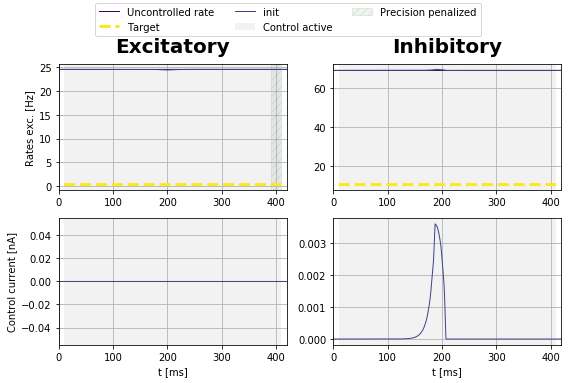

--------- 2


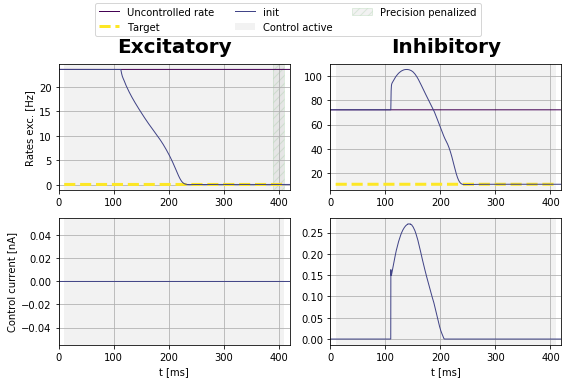

--------- 4


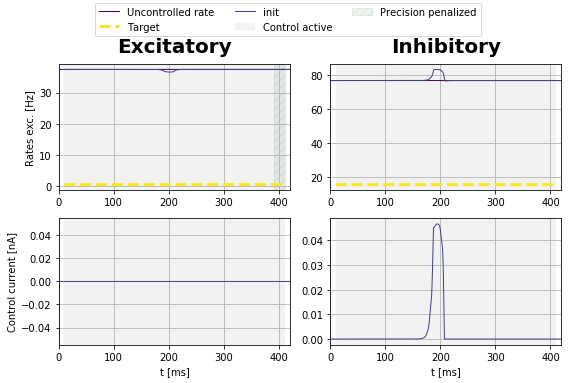

--------- 6


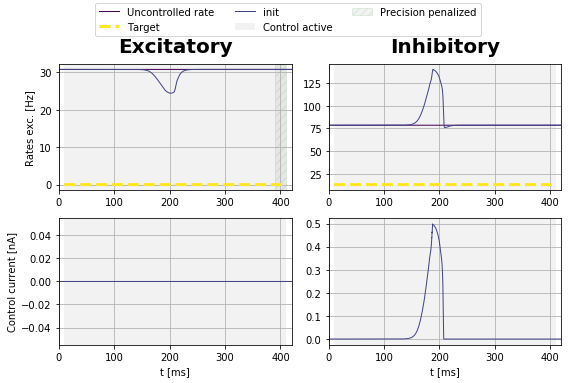

--------- 8


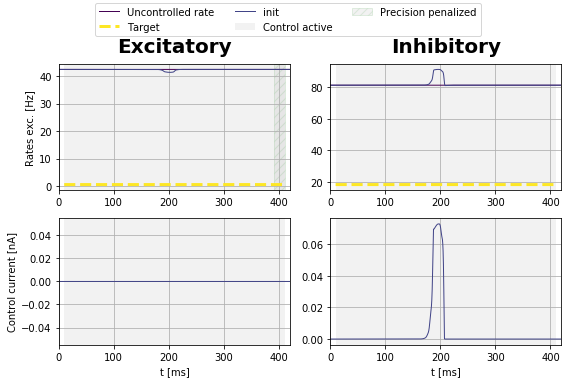

--------- 10


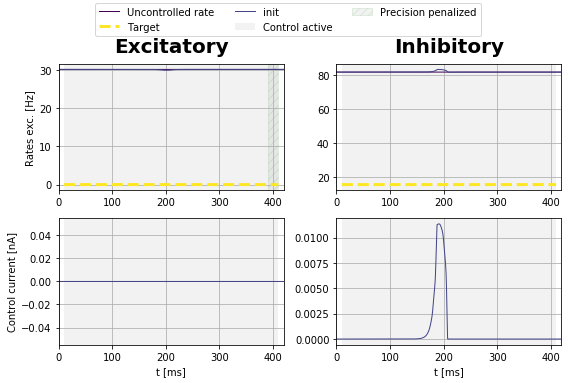

--------- 12


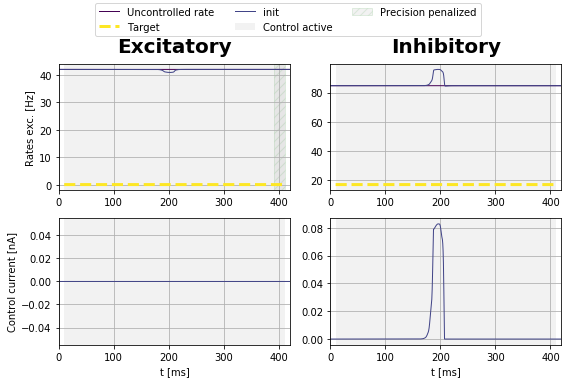

--------- 14


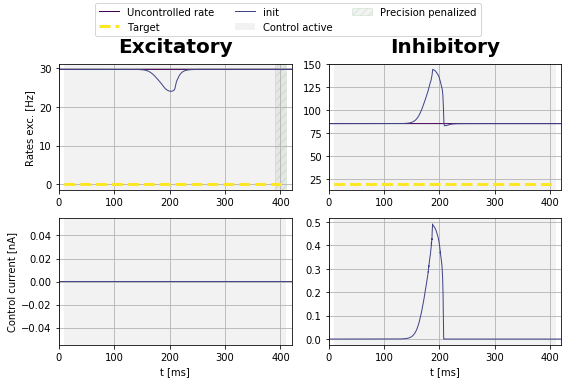

--------- 16


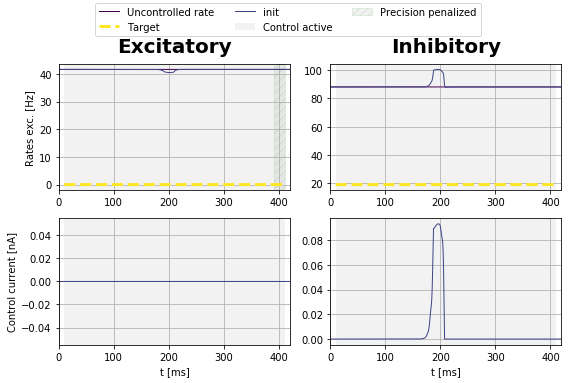

--------- 18


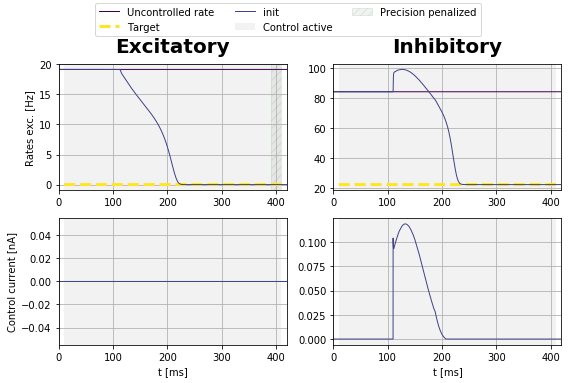

--------- 20


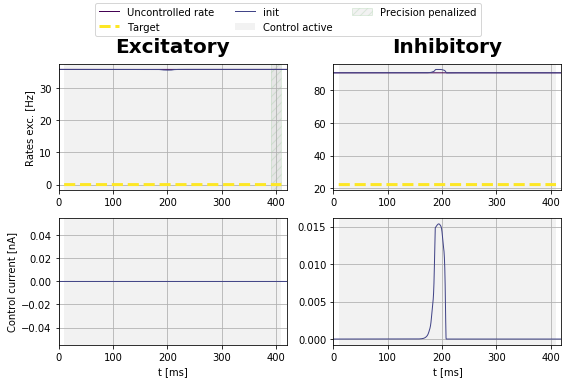

--------- 22


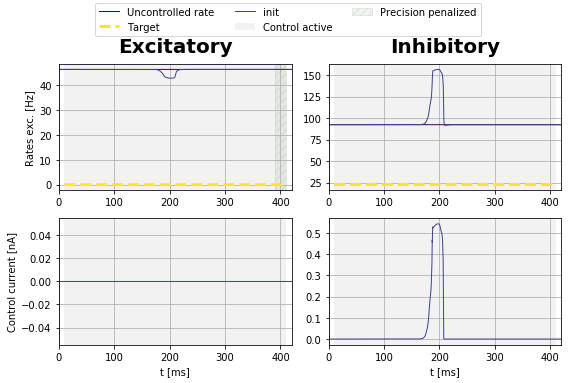

--------- 24


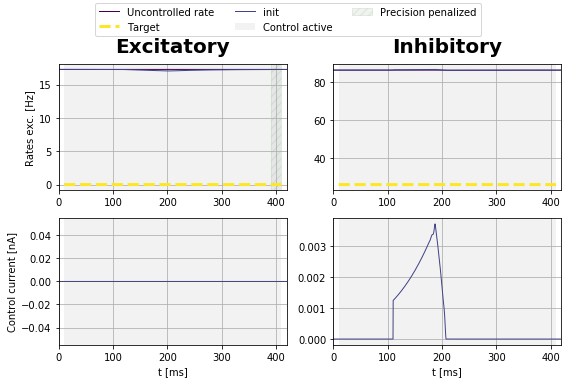

--------- 26


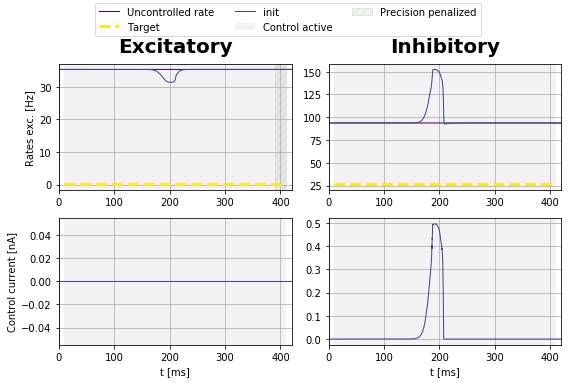

--------- 28


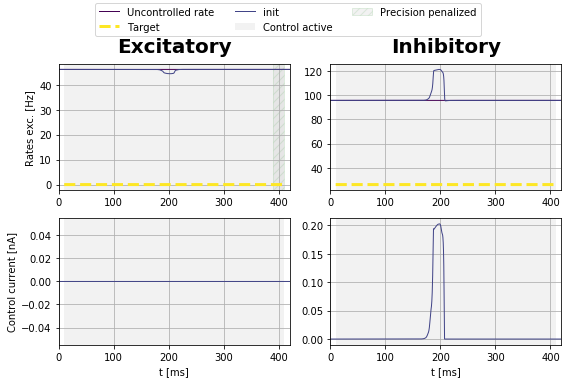

--------- 30


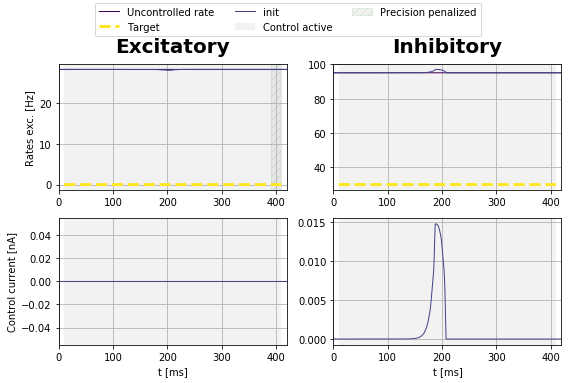

--------- 32


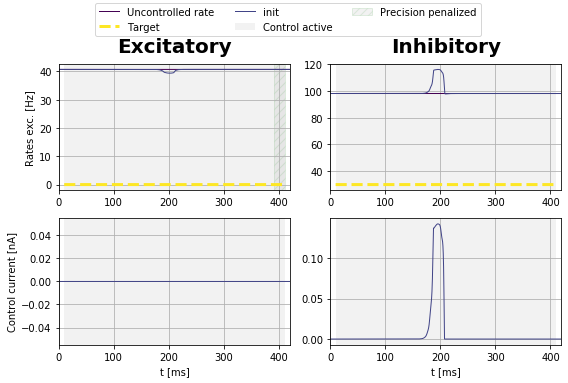

--------- 34


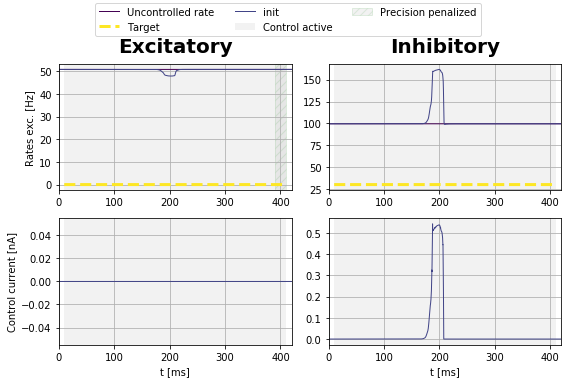

--------- 36


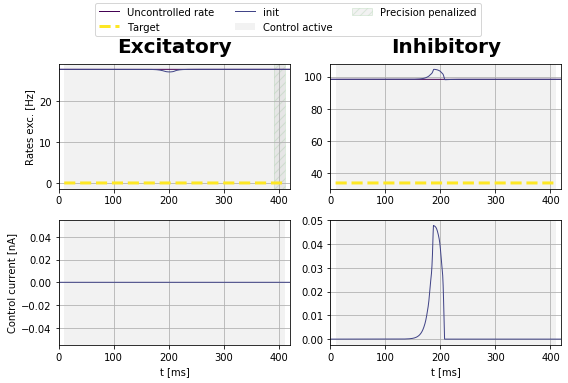

--------- 38


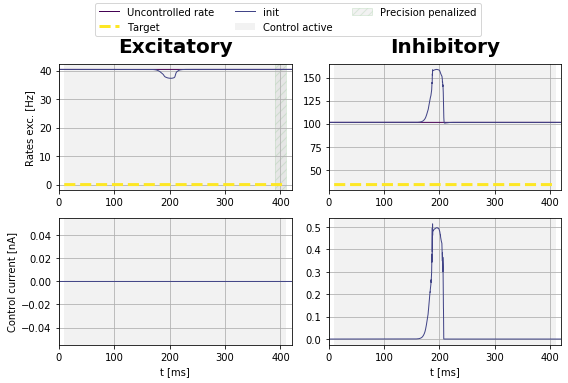

In [15]:

#plot initial guesses
for i in i_range:
    print("---------", i)
        
    aln.params.ext_exc_current = exc[i] * 5.
    aln.params.ext_inh_current = inh[i] * 5.

    plotFunc.plot_control_current(aln, [bestControl_init[i]],
        [costnode_init[i]], [weights_init[i]], dur,
        dur_pre, dur_post, initVars[i], target[i], '', filename_ = '', transition_time_ = trans_time,
        labels_ = ["init", "sparse control" + str(i)], print_cost_ = False)
    plt.show()


In [16]:
found_solution = []
no_solution = []
factor_iteration = 20.

for i in i_range:
    print("------- ", i, exc[i], inh[i])    

    if np.abs(np.mean(bestState_init[i][0,0,-300:]) - target[i][0,0,-1]) < 0.1 * np.abs(
            np.mean(bestState_init[i][0,0,-100:]) - bestState_init[i][0,0,0]) and np.abs(
            np.mean(bestState_init[i][0,1,-100:]) - target[i][0,1,-1]) < 0.5 * np.abs(
            np.mean(bestState_init[i][0,1,-100:]) - bestState_init[i][0,1,0]) and np.amin(
            bestState_init[i][0,0,:]) > target[i][0,0,-1] - 5. and np.amin(
            bestState_init[i][0,1,:]) > target[i][0,1,-1] - 5.:
        # and np.amin(bestState_init[i][0,0,:]) > bestState_init[i][0,0,0] - 1.
        #and np.amin(bestState_init[i][0,1,:]) > bestState_init[i][0,1,0] - 1.:
        if i not in found_solution:
            print("found solution for ", i)
            found_solution.append(i)
        if i in no_solution:
            no_solution.pop(no_solution.index(i))
        

-------  0 0.4000000000000001 0.3500000000000001
-------  2 0.4000000000000001 0.3750000000000001
found solution for  2
-------  4 0.4500000000000001 0.3750000000000001
-------  6 0.4250000000000001 0.40000000000000013
-------  8 0.47500000000000014 0.40000000000000013
-------  10 0.4250000000000001 0.42500000000000016
-------  12 0.47500000000000014 0.42500000000000016
-------  14 0.4250000000000001 0.4500000000000002
-------  16 0.47500000000000014 0.4500000000000002
-------  18 0.4000000000000001 0.4750000000000002
found solution for  18
-------  20 0.4500000000000001 0.4750000000000002
-------  22 0.5000000000000002 0.4750000000000002
-------  24 0.4000000000000001 0.5000000000000002
-------  26 0.4500000000000001 0.5000000000000002
-------  28 0.5000000000000002 0.5000000000000002
-------  30 0.4250000000000001 0.5250000000000002
-------  32 0.47500000000000014 0.5250000000000002
-------  34 0.5250000000000001 0.5250000000000002
-------  36 0.4250000000000001 0.5500000000000003
--

In [17]:
if os.path.isfile(final_file) :
    print("file found")
    
    with open(final_file,'rb') as f:
        load_array = pickle.load(f)

    bestControl_0 = load_array[0]
    bestState_0 = load_array[1]
    cost_0 = load_array[2]
    runtime_0 = load_array[3]
    grad_0 = load_array[4]
    phi_0 = load_array[5]
    costnode_0 = load_array[6]
    weights_0 = load_array[7]

file found


In [18]:
factor_iteration = 6
conv_0 = [[False]*2] * len(exc)
full_converge = False

for i in range(len(conv_0)):
    if i not in i_range_0:
        conv_0[i] = [True, True]

counter = 0

while full_converge == False:
    print('---------------', counter)
    
    if counter > 6:
        break
    
    print(conv_0[::i_stepsize])
    full_converge = True
    
    for conv in conv_0[::i_stepsize]:
        if not conv[0]:
            full_converge = False
            break
        if not conv[1]:
            full_converge = False
            break
    
    if full_converge:
        print("full convergence")
        break
        
    counter += 1
    
    for i in i_range_0:
        print("------- ", i, exc[i], inh[i])
        
        if conv_0[i] == [True, True]:
            continue
            
        aln.params.ext_exc_current = exc[i] * 5.
        aln.params.ext_inh_current = inh[i] * 5.

    # exc and inh control current 

        setinit(initVars[i], aln)
        aln.params.duration = dur

        if not type(bestControl_0[i]) == type(None):
            control0 = bestControl_0[i][:,:,n_pre-1:-n_post+1]
        else:
            control0 = bestControl_init[i][:,:,n_pre-1:-n_post+1].copy()
            weights_0[i] = weights_init[i]
            cost_0[i] = cost_init[i]

        cgv = None
        max_it = 500 * factor_iteration

        j = 1
        while cost_0[i][-j] == 0.:
            j += 1

        weight_ = (factor_we * weights_0[i][1] * cost_uncontrolled[i] / cost_0[i][-j]
                           + factor_ws * weights_0[i][2] * cost_uncontrolled[i] / cost_0[i][-j]) - 1
        print("weight = ", weight_)
        cost.setParams(1.0, weight_ * factor_we, weight_ * factor_ws)

        weights_0[i] = cost.getParams()

        bestControl_0[i], bestState_0[i], cost_0[i], runtime_0[i], grad_0[i], phi_0[i], costnode_0[i] = aln.A1(
            control0, target[i], c_scheme, u_mat, u_scheme, max_iteration_ = max_it, tolerance_ = tol,
            startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl, t_sim_ = dur,
            t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = cgv, control_variables_ = cntrl_vars_0,
            prec_variables_ = prec_vars, transition_time_ = trans_time)

        with open(final_file,'wb') as f:
            pickle.dump([bestControl_0, bestState_0, cost_0, runtime_0, grad_0, phi_0,
                     costnode_0, weights_0], f)
            
        if j == cost_0[i].shape[0]-1:
            print("converged for ", i)
            if conv_0[i][0]:
                conv_0[i] = [True, True]
            else:
                conv_0[i] = [True, False]
            continue
    
        print("no convergence")

--------------- 0
[[False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [Tr

ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  5902.043526454605
Control only changes marginally.
RUN  1 , total integrated cost =  5902.043526454605
Improved over  1  iterations in  14.462420399999985  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -62.73816320622827 -62.77118060789516
converged for  0
-------  2 0.4000000000000001 0.3750000000000001
weight =  120.96756985432432
set cost params:  1.0 120.96756985432432 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  5493.296446940033
Gradient descend method:  None
RUN  1 , total integrated cost =  5095.197656068946
RUN  2 , total integrated cost =  5074.058840261354
RUN  3 , total integrated cost =  361.66521240703946
RUN  4 , total integrated cost =  30.669473202296945
RUN  5 , total integrated cost =  30.46749594201484
RUN  6 , total integrated cost =  30.459005902080285
RUN  7 , total integrated cost =  30.45894574948719
RUN  8 , total integrated cost =  30.45889413470168
RUN  9 , total integr

ERROR:root:Problem in initial value trasfer


RUN  3000 , total integrated cost =  30.062271504364855
RUN  3000 , total integrated cost =  30.062271504364855
Improved over  3000  iterations in  586.2145054  seconds by  99.45274623725959  percent.
Problem in initial value trasfer:  Vmean_exc -65.49893017162657 -65.49848721713198
no convergence
-------  4 0.4500000000000001 0.3750000000000001
weight =  15936.58235605044
set cost params:  1.0 15936.58235605044 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  12224.81953019085
Gradient descend method:  None
RUN  1 , total integrated cost =  12206.345196115604
RUN  2 , total integrated cost =  12206.345196115599
RUN  3 , total integrated cost =  12206.345196115597
State only changes marginally.


ERROR:root:Problem in initial value trasfer


RUN  4 , total integrated cost =  12206.345196115597
Control only changes marginally.
RUN  4 , total integrated cost =  12206.345196115597
Improved over  4  iterations in  1.4301020999999992  seconds by  0.15112152804897505  percent.
Problem in initial value trasfer:  Vmean_exc -56.66707525063507 -56.667448375279385
no convergence
-------  6 0.4250000000000001 0.40000000000000013
weight =  11.821508107453257
set cost params:  1.0 11.821508107453257 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  10213.539444598428
Gradient descend method:  None
RUN  1 , total integrated cost =  916.5433134433799
RUN  2 , total integrated cost =  118.93017810890682
RUN  3 , total integrated cost =  81.21343513541922
RUN  4 , total integrated cost =  68.14276187344201
RUN  5 , total integrated cost =  56.06782628437955
RUN  6 , total integrated cost =  50.38208976685556
RUN  7 , total integrated cost =  44.94706446576576
RUN  8 , total integrated cost =  41.865740090956514
RUN

ERROR:root:Problem in initial value trasfer


Control only changes marginally.
RUN  561 , total integrated cost =  14.687548791612048
Improved over  561  iterations in  110.2465459  seconds by  99.85619530945876  percent.
Problem in initial value trasfer:  Vmean_exc -66.08136279079628 -66.08218236983512
no convergence
-------  8 0.47500000000000014 0.40000000000000013
weight =  13641.898171829214
set cost params:  1.0 13641.898171829214 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  15738.791116034727
Gradient descend method:  None
RUN  1 , total integrated cost =  15711.8610850246
RUN  2 , total integrated cost =  15711.86108502459


ERROR:root:Problem in initial value trasfer


RUN  3 , total integrated cost =  15711.86108502459
Control only changes marginally.
RUN  3 , total integrated cost =  15711.86108502459
Improved over  3  iterations in  1.0261527000000115  seconds by  0.1711060958341335  percent.
Problem in initial value trasfer:  Vmean_exc -56.683323592746405 -56.68373204260481
no convergence
-------  10 0.4250000000000001 0.42500000000000016
weight =  8365.524512255775
set cost params:  1.0 8365.524512255775 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  9110.367453003533
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  9110.367453003533
Control only changes marginally.
RUN  1 , total integrated cost =  9110.367453003533
Improved over  1  iterations in  0.5225573000000168  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -61.145963891244136 -61.179767636807085
converged for  10
-------  12 0.47500000000000014 0.42500000000000016
weight =  13925.209034269812
set cost params:  1.0 13925.209034269812 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  15769.672318692075
Gradient descend method:  None
RUN  1 , total integrated cost =  15745.314781002515
RUN  2 , total integrated cost =  15745.314781002502


ERROR:root:Problem in initial value trasfer


RUN  3 , total integrated cost =  15745.314781002502
Control only changes marginally.
RUN  3 , total integrated cost =  15745.314781002502
Improved over  3  iterations in  1.0925932000000103  seconds by  0.154458109194195  percent.
Problem in initial value trasfer:  Vmean_exc -56.681969356538644 -56.68238828005187
no convergence
-------  14 0.4250000000000001 0.4500000000000002
weight =  11.34066150854532
set cost params:  1.0 11.34066150854532 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  9506.980691505916
Gradient descend method:  None
RUN  1 , total integrated cost =  830.3166908192377
RUN  2 , total integrated cost =  101.47566716944843
RUN  3 , total integrated cost =  67.87878826860377
RUN  4 , total integrated cost =  57.50039246411525
RUN  5 , total integrated cost =  47.09716987105864
RUN  6 , total integrated cost =  42.259411613626185
RUN  7 , total integrated cost =  37.51925763807683
RUN  8 , total integrated cost =  34.742987177558575
RUN  9 

ERROR:root:Problem in initial value trasfer


Control only changes marginally.
RUN  243 , total integrated cost =  11.168373578336153
Improved over  243  iterations in  44.682113999999956  seconds by  99.88252449499225  percent.
Problem in initial value trasfer:  Vmean_exc -68.80881695364945 -68.82156422115418
no convergence
-------  16 0.47500000000000014 0.4500000000000002
weight =  12637.919726076481
set cost params:  1.0 12637.919726076481 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  15383.240083962319
Gradient descend method:  None
RUN  1 , total integrated cost =  15346.759504220003
RUN  2 , total integrated cost =  15346.727877058409
RUN  3 , total integrated cost =  15346.72787624717
RUN  4 , total integrated cost =  15346.727876247165
RUN  5 , total integrated cost =  15346.727876247163
RUN  6 , total integrated cost =  15346.727876247161


ERROR:root:Problem in initial value trasfer


RUN  7 , total integrated cost =  15346.727876247161
Control only changes marginally.
RUN  7 , total integrated cost =  15346.727876247161
Improved over  7  iterations in  2.051351600000089  seconds by  0.23735056799394272  percent.
Problem in initial value trasfer:  Vmean_exc -56.679735600264976 -56.68018781201855
no convergence
-------  18 0.4000000000000001 0.4750000000000002
weight =  434.6271180106597
set cost params:  1.0 434.6271180106597 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  3662.731946981508
Gradient descend method:  None
RUN  1 , total integrated cost =  2350.267699742836
RUN  2 , total integrated cost =  2322.405229671753
RUN  3 , total integrated cost =  2321.3755250247955
RUN  4 , total integrated cost =  2318.5277490880953
RUN  5 , total integrated cost =  2318.2494647236
RUN  6 , total integrated cost =  2315.7399804486076
RUN  7 , total integrated cost =  2315.4427172090286
RUN  8 , total integrated cost =  2313.033295628925
RUN  9 

ERROR:root:Problem in initial value trasfer


Control only changes marginally.
RUN  259 , total integrated cost =  8.983005674824248
Improved over  259  iterations in  53.3695778  seconds by  99.75474575249146  percent.
Problem in initial value trasfer:  Vmean_exc -72.0945135433096 -72.1126368511087
no convergence
-------  20 0.4500000000000001 0.4750000000000002
weight =  111266.91027884264
set cost params:  1.0 111266.91027884264 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  12529.73405573946
Gradient descend method:  None
RUN  1 , total integrated cost =  12529.680179011582
RUN  2 , total integrated cost =  12529.680179011575
RUN  3 , total integrated cost =  12529.680179011573


ERROR:root:Problem in initial value trasfer


RUN  4 , total integrated cost =  12529.680179011573
Control only changes marginally.
RUN  4 , total integrated cost =  12529.680179011573
Improved over  4  iterations in  1.5826982999999473  seconds by  0.0004299909929983414  percent.
Problem in initial value trasfer:  Vmean_exc -56.667643845319375 -56.66769866563199
no convergence
-------  22 0.5000000000000002 0.4750000000000002
weight =  9.773109803341804
set cost params:  1.0 9.773109803341804 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  22276.607645860986
Gradient descend method:  None
RUN  1 , total integrated cost =  1131.9801504049738
RUN  2 , total integrated cost =  305.33404628354873
RUN  3 , total integrated cost =  200.06851239704002
RUN  4 , total integrated cost =  169.78263569355093
RUN  5 , total integrated cost =  145.50776244901664
RUN  6 , total integrated cost =  134.31259941106035
RUN  7 , total integrated cost =  125.10626901488757
RUN  8 , total integrated cost =  119.394576007087

ERROR:root:Problem in initial value trasfer


Control only changes marginally.
RUN  347 , total integrated cost =  67.65110927106957
Improved over  347  iterations in  78.55433100000005  seconds by  99.6963132342835  percent.
Problem in initial value trasfer:  Vmean_exc -64.2049151611134 -64.21519764977407
no convergence
-------  24 0.4000000000000001 0.5000000000000002
weight =  1605186.8089088679
set cost params:  1.0 1605186.8089088679 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  2980.9797647519786
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  2980.9797647519786
Control only changes marginally.
RUN  1 , total integrated cost =  2980.9797647519786
Improved over  1  iterations in  0.7381884999999784  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -68.2217205744218 -68.27233136962545
no convergence
-------  26 0.4500000000000001 0.5000000000000002
weight =  10.141391802385387
set cost params:  1.0 10.141391802385387 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  13101.490112359268
Gradient descend method:  None
RUN  1 , total integrated cost =  826.4732224354685
RUN  2 , total integrated cost =  159.0406442943923
RUN  3 , total integrated cost =  105.8358818469442
RUN  4 , total integrated cost =  88.6868463364911
RUN  5 , total integrated cost =  74.13536766866233
RUN  6 , total integrated cost =  67.27028108571731
RUN  7 , total integrated cost =  61.1296043309665
RUN  8 , total integrated cost =  57.33521473831181
RUN  9 , total integrated

ERROR:root:Problem in initial value trasfer


Control only changes marginally.
RUN  237 , total integrated cost =  22.804732079469687
Improved over  237  iterations in  46.07978479999997  seconds by  99.82593787512798  percent.
Problem in initial value trasfer:  Vmean_exc -68.76767143052493 -68.7868665358411
no convergence
-------  28 0.5000000000000002 0.5000000000000002
weight =  12550.453963241012
set cost params:  1.0 12550.453963241012 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  19101.937199336382
Gradient descend method:  None
RUN  1 , total integrated cost =  19071.21086617312
RUN  2 , total integrated cost =  19071.20221797457
RUN  3 , total integrated cost =  19071.20221128077


ERROR:root:Problem in initial value trasfer


RUN  4 , total integrated cost =  19071.20221128077
Control only changes marginally.
RUN  4 , total integrated cost =  19071.20221128077
Improved over  4  iterations in  1.0612052000001313  seconds by  0.1608998487162836  percent.
Problem in initial value trasfer:  Vmean_exc -56.692116063885315 -56.69251955688711
no convergence
-------  30 0.4250000000000001 0.5250000000000002
weight =  11407.881860780466
set cost params:  1.0 11407.881860780466 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  7977.617874239231
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  7977.617874239231
Control only changes marginally.
RUN  1 , total integrated cost =  7977.617874239231
Improved over  1  iterations in  0.49556250000000546  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -64.08847723114495 -64.14329105953175
converged for  30
-------  32 0.47500000000000014 0.5250000000000002
weight =  4234.514886472701
set cost params:  1.0 4234.514886472701 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16564.30664309458
Gradient descend method:  None
RUN  1 , total integrated cost =  16564.30664309457
RUN  2 , total integrated cost =  16564.306643094555
RUN  3 , total integrated cost =  16564.306643094544
RUN  4 , total integrated cost =  16564.306643094533
RUN  5 , total integrated cost =  16564.30664309453
RUN  6 , total integrated cost =  16564.306643094525


ERROR:root:Problem in initial value trasfer


RUN  7 , total integrated cost =  16564.306643094525
Control only changes marginally.
RUN  7 , total integrated cost =  16564.306643094525
Improved over  7  iterations in  2.5678771000000324  seconds by  3.268496584496461e-13  percent.
Problem in initial value trasfer:  Vmean_exc -58.71263031021543 -58.717099727985456
no convergence
-------  34 0.5250000000000001 0.5250000000000002
weight =  9.547002945747241
set cost params:  1.0 9.547002945747241 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  26426.36995362511
Gradient descend method:  None
RUN  1 , total integrated cost =  1177.3492632496066
RUN  2 , total integrated cost =  381.2570044240491
RUN  3 , total integrated cost =  245.48776593892666
RUN  4 , total integrated cost =  209.38134625314345
RUN  5 , total integrated cost =  177.39879005163664
RUN  6 , total integrated cost =  163.9182391137796
RUN  7 , total integrated cost =  152.64552674494266
RUN  8 , total integrated cost =  145.31710551685586


ERROR:root:Problem in initial value trasfer


Control only changes marginally.
RUN  264 , total integrated cost =  89.49130212642793
Improved over  264  iterations in  48.51237149999997  seconds by  99.6613560535046  percent.
Problem in initial value trasfer:  Vmean_exc -63.65806106982484 -63.670387042075774
no convergence
-------  36 0.4250000000000001 0.5500000000000003
weight =  12326.422511254197
set cost params:  1.0 12326.422511254197 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  7741.039729516906
Gradient descend method:  None
RUN  1 , total integrated cost =  7741.039729516896
RUN  2 , total integrated cost =  7741.039729516895
RUN  3 , total integrated cost =  7741.039729516893
RUN  4 , total integrated cost =  7741.039729516892


ERROR:root:Problem in initial value trasfer


RUN  5 , total integrated cost =  7741.039729516892
Control only changes marginally.
RUN  5 , total integrated cost =  7741.039729516892
Improved over  5  iterations in  2.1389308999998775  seconds by  1.7053025658242404e-13  percent.
Problem in initial value trasfer:  Vmean_exc -65.29054470395353 -65.34788881242851
converged for  36
-------  38 0.47500000000000014 0.5500000000000003
weight =  9.701891297581199
set cost params:  1.0 9.701891297581199 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16926.167498513412
Gradient descend method:  None
RUN  1 , total integrated cost =  877.505555748922
RUN  2 , total integrated cost =  228.5232701226853
RUN  3 , total integrated cost =  148.9020592858956
RUN  4 , total integrated cost =  126.23510417380083
RUN  5 , total integrated cost =  105.75144816671137
RUN  6 , total integrated cost =  96.30678368608277
RUN  7 , total integrated cost =  87.95077693790849
RUN  8 , total integrated cost =  82.60932552655176
RU

ERROR:root:Problem in initial value trasfer


Control only changes marginally.
RUN  291 , total integrated cost =  38.334291933316194
Improved over  291  iterations in  54.19461119999983  seconds by  99.77352054482101  percent.
Problem in initial value trasfer:  Vmean_exc -67.9780509886479 -68.00132343056848
no convergence
--------------- 1
[[True, False], [False, False], [False, False], [False, False], [False, False], [True, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [True, False], [False, False], [False, False], [True, False], [False, False], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, T

ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  5902.043526454605
Control only changes marginally.
RUN  1 , total integrated cost =  5902.043526454605
Improved over  1  iterations in  0.5725961000000552  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -62.73816320622827 -62.77118060789516
converged for  0
-------  2 0.4000000000000001 0.3750000000000001
weight =  22286.205343927057
set cost params:  1.0 22286.205343927057 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  5538.41522569797
Gradient descend method:  None
RUN  1 , total integrated cost =  5538.33238042341
RUN  2 , total integrated cost =  5538.33203411435
RUN  3 , total integrated cost =  5538.332034089196
RUN  4 , total integrated cost =  5538.332034082553
RUN  5 , total integrated cost =  5538.332034078509
RUN  6 , total integrated cost =  5538.332034052968
RUN  7 , total integrated cost =  5538.331871654727
RUN  8 , total integrated cost =  5538.331709158339
RUN  9 , total integrated c

ERROR:root:Problem in initial value trasfer


Control only changes marginally.
RUN  26 , total integrated cost =  5534.084055317045
Improved over  26  iterations in  5.692033300000048  seconds by  0.07820234136343629  percent.
Problem in initial value trasfer:  Vmean_exc -65.97040677287687 -65.96704178274948
no convergence
-------  4 0.4500000000000001 0.3750000000000001
weight =  17758.094865884344
set cost params:  1.0 17758.094865884344 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  12357.597123461577
Gradient descend method:  None
RUN  1 , total integrated cost =  12342.883665292287
RUN  2 , total integrated cost =  12342.867097032378
RUN  3 , total integrated cost =  12342.867090952726
RUN  4 , total integrated cost =  12342.867090952717
RUN  5 , total integrated cost =  12342.867090952714


ERROR:root:Problem in initial value trasfer


RUN  6 , total integrated cost =  12342.867090952714
Control only changes marginally.
RUN  6 , total integrated cost =  12342.867090952714
Improved over  6  iterations in  1.7177994999999555  seconds by  0.11919819331946258  percent.
Problem in initial value trasfer:  Vmean_exc -56.66801472275239 -56.66835581759333
no convergence
-------  6 0.4250000000000001 0.40000000000000013
weight =  7596.191591001481
set cost params:  1.0 7596.191591001481 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  9397.614179170867
Gradient descend method:  None
RUN  1 , total integrated cost =  9212.425552581222
RUN  2 , total integrated cost =  9212.267789470663
RUN  3 , total integrated cost =  9212.241716650202
RUN  4 , total integrated cost =  9211.700974606834
RUN  5 , total integrated cost =  9211.28141004241
RUN  6 , total integrated cost =  9211.27894336801
RUN  7 , total integrated cost =  9211.278487624644
RUN  8 , total integrated cost =  9211.27797928026
RUN  9 , tot

ERROR:root:Problem in initial value trasfer


Control only changes marginally.
RUN  27 , total integrated cost =  9210.430565917919
Improved over  27  iterations in  5.9008331  seconds by  1.9918205800343145  percent.
Problem in initial value trasfer:  Vmean_exc -62.95743247838826 -62.991772715968004
no convergence
-------  8 0.47500000000000014 0.40000000000000013
weight =  15237.86763666119
set cost params:  1.0 15237.86763666119 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  15912.07902770635
Gradient descend method:  None
RUN  1 , total integrated cost =  15894.456201070965
RUN  2 , total integrated cost =  15894.448062642059
RUN  3 , total integrated cost =  15894.448062642043


ERROR:root:Problem in initial value trasfer


RUN  4 , total integrated cost =  15894.448062642043
Control only changes marginally.
RUN  4 , total integrated cost =  15894.448062642043
Improved over  4  iterations in  1.2610193999998955  seconds by  0.11080239755978027  percent.
Problem in initial value trasfer:  Vmean_exc -56.684089784648336 -56.68446404195405
no convergence
-------  10 0.4250000000000001 0.42500000000000016
weight =  8365.524512255775
set cost params:  1.0 8365.524512255775 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  9110.367453003533
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  9110.367453003533
Control only changes marginally.
RUN  1 , total integrated cost =  9110.367453003533
Improved over  1  iterations in  0.5351536000000578  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -61.145963891244136 -61.179767636807085
converged for  10
-------  12 0.47500000000000014 0.42500000000000016
weight =  15539.028173577959
set cost params:  1.0 15539.028173577959 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  15944.239416000552
Gradient descend method:  None
RUN  1 , total integrated cost =  15925.293913745816
RUN  2 , total integrated cost =  15925.293907235458
RUN  3 , total integrated cost =  15925.293907235442
RUN  4 , total integrated cost =  15925.293907235438


ERROR:root:Problem in initial value trasfer


RUN  5 , total integrated cost =  15925.293907235438
Control only changes marginally.
RUN  5 , total integrated cost =  15925.293907235438
Improved over  5  iterations in  2.2784816999999293  seconds by  0.11882353413547264  percent.
Problem in initial value trasfer:  Vmean_exc -56.68278482114223 -56.683149356966325
no convergence
-------  14 0.4250000000000001 0.4500000000000002
weight =  8930.8689873618
set cost params:  1.0 8930.8689873618 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  8760.749804461506
Gradient descend method:  None
RUN  1 , total integrated cost =  8587.861270442569
RUN  2 , total integrated cost =  8587.855664266615
RUN  3 , total integrated cost =  8587.516134255142
RUN  4 , total integrated cost =  8587.172858935473
RUN  5 , total integrated cost =  8587.170586588127
RUN  6 , total integrated cost =  8587.170461436883
RUN  7 , total integrated cost =  8587.170455004321
RUN  8 , total integrated cost =  8587.170448519224
RUN  9 , tot

ERROR:root:Problem in initial value trasfer


RUN  15 , total integrated cost =  8587.170448336725
Control only changes marginally.
RUN  15 , total integrated cost =  8587.170448336725
Improved over  15  iterations in  3.534162400000014  seconds by  1.9813299089580596  percent.
Problem in initial value trasfer:  Vmean_exc -64.15616431666452 -64.20095332351877
no convergence
-------  16 0.47500000000000014 0.4500000000000002
weight =  14279.104404153164
set cost params:  1.0 14279.104404153164 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  15590.249271299374
Gradient descend method:  None
RUN  1 , total integrated cost =  15563.323012832698
RUN  2 , total integrated cost =  15563.323012832696
RUN  3 , total integrated cost =  15563.32301283269


ERROR:root:Problem in initial value trasfer


RUN  4 , total integrated cost =  15563.32301283269
Control only changes marginally.
RUN  4 , total integrated cost =  15563.32301283269
Improved over  4  iterations in  2.080163000000084  seconds by  0.17271217411676787  percent.
Problem in initial value trasfer:  Vmean_exc -56.68084293724768 -56.68125030600029
no convergence
-------  18 0.4000000000000001 0.4750000000000002
weight =  177621.6599278358
set cost params:  1.0 177621.6599278358 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  3670.6985985387273
Gradient descend method:  None
RUN  1 , total integrated cost =  3668.3896737560717
RUN  2 , total integrated cost =  3668.3734680273674
RUN  3 , total integrated cost =  3668.373442014272
RUN  4 , total integrated cost =  3668.3734416550456
RUN  5 , total integrated cost =  3668.373441655027
RUN  6 , total integrated cost =  3668.3734416550174
RUN  7 , total integrated cost =  3668.373441655017


ERROR:root:Problem in initial value trasfer


RUN  8 , total integrated cost =  3668.373441655017
Control only changes marginally.
RUN  8 , total integrated cost =  3668.373441655017
Improved over  8  iterations in  2.2992007000000285  seconds by  0.06334371567952246  percent.
Problem in initial value trasfer:  Vmean_exc -70.37746520250009 -70.40497924340403
no convergence
-------  20 0.4500000000000001 0.4750000000000002
weight =  113116.88010103791
set cost params:  1.0 113116.88010103791 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  12533.1272824403
Gradient descend method:  None
RUN  1 , total integrated cost =  12533.073988175378
RUN  2 , total integrated cost =  12533.073942293684
RUN  3 , total integrated cost =  12533.073942293677
RUN  4 , total integrated cost =  12533.073942293675


ERROR:root:Problem in initial value trasfer


RUN  5 , total integrated cost =  12533.073942293675
Control only changes marginally.
RUN  5 , total integrated cost =  12533.073942293675
Improved over  5  iterations in  1.7521166999999878  seconds by  0.0004255932731211942  percent.
Problem in initial value trasfer:  Vmean_exc -56.66766686758895 -56.66772047771418
no convergence
-------  22 0.5000000000000002 0.4750000000000002
weight =  3114.379049508724
set cost params:  1.0 3114.379049508724 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  21244.34596726188
Gradient descend method:  None
RUN  1 , total integrated cost =  20322.0913716036
RUN  2 , total integrated cost =  20319.377872234003
RUN  3 , total integrated cost =  20318.54760796831
RUN  4 , total integrated cost =  20317.830657217597
RUN  5 , total integrated cost =  20311.98535997135
RUN  6 , total integrated cost =  20308.31397900977
RUN  7 , total integrated cost =  20305.992055522027
RUN  8 , total integrated cost =  20304.761605669773
RUN 

ERROR:root:Problem in initial value trasfer


RUN  18 , total integrated cost =  20303.72778210121
Control only changes marginally.
RUN  18 , total integrated cost =  20303.72778210121
Improved over  18  iterations in  4.311476899999889  seconds by  4.427616583773343  percent.
Problem in initial value trasfer:  Vmean_exc -57.74275458967205 -57.73132977942349
no convergence
-------  24 0.4000000000000001 0.5000000000000002
weight =  1605186.8089088688
set cost params:  1.0 1605186.8089088688 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  2980.979764751979
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  2980.979764751979
Control only changes marginally.
RUN  1 , total integrated cost =  2980.979764751979
Improved over  1  iterations in  0.7155248999999912  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -68.2217205744218 -68.27233136962545
converged for  24
-------  26 0.4500000000000001 0.5000000000000002
weight =  5548.785491639479
set cost params:  1.0 5548.785491639479 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  12410.383054111266
Gradient descend method:  None
RUN  1 , total integrated cost =  12116.876276844772
RUN  2 , total integrated cost =  12114.188443753808
RUN  3 , total integrated cost =  12114.17057956921
RUN  4 , total integrated cost =  12114.124199671562
RUN  5 , total integrated cost =  12114.122518548225
RUN  6 , total integrated cost =  12114.122516070045
RUN  7 , total integrated cost =  12114.122516027639
RUN  8 , total integrated cost =  12114.122516023743
RUN  9 , total in

ERROR:root:Problem in initial value trasfer


RUN  14 , total integrated cost =  12114.122516023273
Control only changes marginally.
RUN  14 , total integrated cost =  12114.122516023273
Improved over  14  iterations in  3.4676527000001443  seconds by  2.387198983272711  percent.
Problem in initial value trasfer:  Vmean_exc -62.031319653133394 -62.06838705335096
no convergence
-------  28 0.5000000000000002 0.5000000000000002
weight =  14024.806386556995
set cost params:  1.0 14024.806386556995 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  19319.30459625187
Gradient descend method:  None
RUN  1 , total integrated cost =  19294.220325956525
RUN  2 , total integrated cost =  19294.220325956507


ERROR:root:Problem in initial value trasfer


RUN  3 , total integrated cost =  19294.220325956507
Control only changes marginally.
RUN  3 , total integrated cost =  19294.220325956507
Improved over  3  iterations in  1.0912934000000405  seconds by  0.1298404410489411  percent.
Problem in initial value trasfer:  Vmean_exc -56.69281935865381 -56.69315631109511
no convergence
-------  30 0.4250000000000001 0.5250000000000002
weight =  11407.881860780468
set cost params:  1.0 11407.881860780468 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  7977.617874239234
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  7977.617874239234
Control only changes marginally.
RUN  1 , total integrated cost =  7977.617874239234
Improved over  1  iterations in  0.5382362000000285  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -64.08847723114495 -64.14329105953175
converged for  30
-------  32 0.47500000000000014 0.5250000000000002
weight =  4234.514886472715
set cost params:  1.0 4234.514886472715 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16564.30664309461
Gradient descend method:  None
RUN  1 , total integrated cost =  16564.306643094587
RUN  2 , total integrated cost =  16564.306643094584


ERROR:root:Problem in initial value trasfer


RUN  3 , total integrated cost =  16564.306643094584
Control only changes marginally.
RUN  3 , total integrated cost =  16564.306643094584
Improved over  3  iterations in  1.3518541999999343  seconds by  1.5631940186722204e-13  percent.
Problem in initial value trasfer:  Vmean_exc -58.71263031019111 -58.71709972796092
no convergence
-------  34 0.5250000000000001 0.5250000000000002
weight =  2747.0641518542106
set cost params:  1.0 2747.0641518542106 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  25258.36342769398
Gradient descend method:  None
RUN  1 , total integrated cost =  23958.080579040015
RUN  2 , total integrated cost =  23948.436975373035
RUN  3 , total integrated cost =  23945.326566437176
RUN  4 , total integrated cost =  23944.46700627664
RUN  5 , total integrated cost =  23944.016183818276
RUN  6 , total integrated cost =  23943.49433897333
RUN  7 , total integrated cost =  23943.1472090553
RUN  8 , total integrated cost =  23942.526309434612


ERROR:root:Problem in initial value trasfer


Control only changes marginally.
RUN  882 , total integrated cost =  16359.839556200248
Improved over  882  iterations in  182.95939750000002  seconds by  35.23000964400228  percent.
Problem in initial value trasfer:  Vmean_exc -56.67808085144316 -56.680113424981606
no convergence
-------  36 0.4250000000000001 0.5500000000000003
weight =  12326.422511254204
set cost params:  1.0 12326.422511254204 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  7741.039729516899
Gradient descend method:  None
RUN  1 , total integrated cost =  7741.039729516898


ERROR:root:Problem in initial value trasfer


RUN  2 , total integrated cost =  7741.039729516898
Control only changes marginally.
RUN  2 , total integrated cost =  7741.039729516898
Improved over  2  iterations in  1.1751445999998396  seconds by  1.4210854715202004e-14  percent.
Problem in initial value trasfer:  Vmean_exc -65.29054470395353 -65.34788881242851
no convergence
-------  38 0.47500000000000014 0.5500000000000003
weight =  4135.604539755895
set cost params:  1.0 4135.604539755895 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16191.220906897866
Gradient descend method:  None
RUN  1 , total integrated cost =  15628.315258970957
RUN  2 , total integrated cost =  15627.925175833892
RUN  3 , total integrated cost =  15627.829384941779
RUN  4 , total integrated cost =  15627.710059197425
RUN  5 , total integrated cost =  15627.702350558588
RUN  6 , total integrated cost =  15626.001417440784
RUN  7 , total integrated cost =  15624.771254670757
RUN  8 , total integrated cost =  15624.76707077442

ERROR:root:Problem in initial value trasfer


Control only changes marginally.
RUN  34 , total integrated cost =  15624.09874906723
Improved over  34  iterations in  8.11809530000005  seconds by  3.5026522156153703  percent.
Problem in initial value trasfer:  Vmean_exc -59.67774452771134 -59.69278167124243
no convergence
--------------- 2
[[True, True], [False, False], [False, False], [False, False], [False, False], [True, True], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [True, False], [False, False], [False, False], [True, True], [False, False], [False, False], [True, False], [False, False], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], 

ERROR:root:Problem in initial value trasfer


RUN  5 , total integrated cost =  5538.459439746555
Control only changes marginally.
RUN  5 , total integrated cost =  5538.459439746555
Improved over  5  iterations in  2.716609500000004  seconds by  3.836930773104541e-13  percent.
Problem in initial value trasfer:  Vmean_exc -65.9704068111648 -65.96704182087745
no convergence
-------  4 0.4500000000000001 0.3750000000000001
weight =  19569.03501242766
set cost params:  1.0 19569.03501242766 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  12465.595555956816
Gradient descend method:  None
RUN  1 , total integrated cost =  12454.407188438272
RUN  2 , total integrated cost =  12454.394119869934
RUN  3 , total integrated cost =  12454.394118554756
RUN  4 , total integrated cost =  12454.394118554746


ERROR:root:Problem in initial value trasfer


RUN  5 , total integrated cost =  12454.394118554746
Control only changes marginally.
RUN  5 , total integrated cost =  12454.394118554746
Improved over  5  iterations in  1.4573163000000022  seconds by  0.08985882264337874  percent.
Problem in initial value trasfer:  Vmean_exc -56.66878772700403 -56.66908910925315
no convergence
-------  6 0.4250000000000001 0.40000000000000013
weight =  7783.7647645191
set cost params:  1.0 7783.7647645191 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  9437.119662205681
Gradient descend method:  None
RUN  1 , total integrated cost =  9437.114685013254
RUN  2 , total integrated cost =  9437.114343360707
RUN  3 , total integrated cost =  9437.11424424187
RUN  4 , total integrated cost =  9437.114178709466
RUN  5 , total integrated cost =  9437.114146267644
RUN  6 , total integrated cost =  9437.114076307942
RUN  7 , total integrated cost =  9437.113894944021
RUN  8 , total integrated cost =  9437.11221025763
RUN  9 , total 

ERROR:root:Problem in initial value trasfer


RUN  12 , total integrated cost =  9433.383276046963
Control only changes marginally.
RUN  12 , total integrated cost =  9433.383276046963
Improved over  12  iterations in  4.131893799999943  seconds by  0.03959244231776893  percent.
Problem in initial value trasfer:  Vmean_exc -62.91016737823382 -62.94460820605947
no convergence
-------  8 0.47500000000000014 0.40000000000000013
weight =  16825.13113362346
set cost params:  1.0 16825.13113362346 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16058.038319197098
Gradient descend method:  None
RUN  1 , total integrated cost =  16043.307346308897
RUN  2 , total integrated cost =  16043.30734630889
RUN  3 , total integrated cost =  16043.307346308884


ERROR:root:Problem in initial value trasfer


RUN  4 , total integrated cost =  16043.307346308884
Control only changes marginally.
RUN  4 , total integrated cost =  16043.307346308884
Improved over  4  iterations in  1.499111800000037  seconds by  0.09173581850656376  percent.
Problem in initial value trasfer:  Vmean_exc -56.68476759521454 -56.685092324310325
no convergence
-------  10 0.4250000000000001 0.42500000000000016
-------  12 0.47500000000000014 0.42500000000000016
weight =  17144.01321093732
set cost params:  1.0 17144.01321093732 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16086.813014074689
Gradient descend method:  None
RUN  1 , total integrated cost =  16072.30066812547
RUN  2 , total integrated cost =  16072.30066812546


ERROR:root:Problem in initial value trasfer


RUN  3 , total integrated cost =  16072.30066812546
Control only changes marginally.
RUN  3 , total integrated cost =  16072.30066812546
Improved over  3  iterations in  1.1065750000000207  seconds by  0.0902126849894529  percent.
Problem in initial value trasfer:  Vmean_exc -56.683468379709105 -56.68380237050255
no convergence
-------  14 0.4250000000000001 0.4500000000000002
weight =  9147.239457345471
set cost params:  1.0 9147.239457345471 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  8794.503961759867
Gradient descend method:  None
RUN  1 , total integrated cost =  8794.499108367627
RUN  2 , total integrated cost =  8794.498937627905
RUN  3 , total integrated cost =  8794.49891163931
RUN  4 , total integrated cost =  8794.498907962736
RUN  5 , total integrated cost =  8794.498907749487
RUN  6 , total integrated cost =  8794.498907746007
RUN  7 , total integrated cost =  8794.498907745978
RUN  8 , total integrated cost =  8794.498907745972


ERROR:root:Problem in initial value trasfer


RUN  9 , total integrated cost =  8794.498907745972
Control only changes marginally.
RUN  9 , total integrated cost =  8794.498907745972
Improved over  9  iterations in  2.251816700000063  seconds by  5.746786762017564e-05  percent.
Problem in initial value trasfer:  Vmean_exc -64.10608205030773 -64.15096734585251
no convergence
-------  16 0.47500000000000014 0.4500000000000002
weight =  15909.001492535326
set cost params:  1.0 15909.001492535326 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  15753.821213390427
Gradient descend method:  None
RUN  1 , total integrated cost =  15736.386215653052
RUN  2 , total integrated cost =  15736.386215653032


ERROR:root:Problem in initial value trasfer


RUN  3 , total integrated cost =  15736.386215653032
Control only changes marginally.
RUN  3 , total integrated cost =  15736.386215653032
Improved over  3  iterations in  1.1305887000000894  seconds by  0.11067154756445063  percent.
Problem in initial value trasfer:  Vmean_exc -56.68166878958613 -56.68204173770115
no convergence
-------  18 0.4000000000000001 0.4750000000000002
weight =  177755.54774616755
set cost params:  1.0 177755.54774616755 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  3671.138175966804
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  3671.138175966804
Control only changes marginally.
RUN  1 , total integrated cost =  3671.138175966804
Improved over  1  iterations in  0.5479989000000387  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -70.37746520250009 -70.40497924340403
no convergence
-------  20 0.4500000000000001 0.4750000000000002
weight =  114966.4850601492
set cost params:  1.0 114966.4850601492 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  12536.412318498242
Gradient descend method:  None
RUN  1 , total integrated cost =  12536.35900195004
RUN  2 , total integrated cost =  12536.358985581448
RUN  3 , total integrated cost =  12536.358985581017


ERROR:root:Problem in initial value trasfer


RUN  4 , total integrated cost =  12536.358985581017
Control only changes marginally.
RUN  4 , total integrated cost =  12536.358985581017
Improved over  4  iterations in  1.2890339000000495  seconds by  0.0004254240836161216  percent.
Problem in initial value trasfer:  Vmean_exc -56.667689317561006 -56.6677420844426
no convergence
-------  22 0.5000000000000002 0.4750000000000002
weight =  3306.8722292156326
set cost params:  1.0 3306.8722292156326 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  21550.97764738397
Gradient descend method:  None
RUN  1 , total integrated cost =  20964.897528322752
RUN  2 , total integrated cost =  14390.634077425737
RUN  3 , total integrated cost =  14276.959308657904
RUN  4 , total integrated cost =  14261.985990818179
RUN  5 , total integrated cost =  14261.428523891911
RUN  6 , total integrated cost =  14261.428523891904


ERROR:root:Problem in initial value trasfer


RUN  7 , total integrated cost =  14261.428523891904
Control only changes marginally.
RUN  7 , total integrated cost =  14261.428523891904
Improved over  7  iterations in  1.664435499999854  seconds by  33.824679523886616  percent.
Problem in initial value trasfer:  Vmean_exc -56.66871601494533 -56.67046482362128
no convergence
-------  24 0.4000000000000001 0.5000000000000002
weight =  1605186.8089088695
set cost params:  1.0 1605186.8089088695 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  2980.9797647519813
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  2980.9797647519813
Control only changes marginally.
RUN  1 , total integrated cost =  2980.9797647519813
Improved over  1  iterations in  0.5292905999999675  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -68.2217205744218 -68.27233136962545
converged for  24
-------  26 0.4500000000000001 0.5000000000000002
weight =  5715.2285449769715
set cost params:  1.0 5715.2285449769715 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  12476.151612739526
Gradient descend method:  None
RUN  1 , total integrated cost =  12476.1358653108
RUN  2 , total integrated cost =  12476.135864942704
RUN  3 , total integrated cost =  12476.135864941005
RUN  4 , total integrated cost =  12476.135864940992
RUN  5 , total integrated cost =  12476.135864940987
RUN  6 , total integrated cost =  12476.135864940985


ERROR:root:Problem in initial value trasfer


RUN  7 , total integrated cost =  12476.135864940985
Control only changes marginally.
RUN  7 , total integrated cost =  12476.135864940985
Improved over  7  iterations in  2.539470700000038  seconds by  0.0001262232059247026  percent.
Problem in initial value trasfer:  Vmean_exc -61.96089898837136 -61.99774726138378
no convergence
-------  28 0.5000000000000002 0.5000000000000002
weight =  15491.30778522934
set cost params:  1.0 15491.30778522934 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  19492.790688944187
Gradient descend method:  None
RUN  1 , total integrated cost =  19476.02184172967
RUN  2 , total integrated cost =  19476.021841729664


ERROR:root:Problem in initial value trasfer


RUN  3 , total integrated cost =  19476.021841729664
Control only changes marginally.
RUN  3 , total integrated cost =  19476.021841729664
Improved over  3  iterations in  1.1561977000001207  seconds by  0.08602589276267736  percent.
Problem in initial value trasfer:  Vmean_exc -56.69332451808223 -56.693634708547876
no convergence
-------  30 0.4250000000000001 0.5250000000000002
-------  32 0.47500000000000014 0.5250000000000002
weight =  4234.514886472715
set cost params:  1.0 4234.514886472715 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16564.306643094584
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  16564.306643094584
Control only changes marginally.
RUN  1 , total integrated cost =  16564.306643094584
Improved over  1  iterations in  0.5116627000002154  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -58.71263031019111 -58.71709972796092
no convergence
-------  34 0.5250000000000001 0.5250000000000002
weight =  4324.441063886779
set cost params:  1.0 4324.441063886779 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  20414.984638543116
Gradient descend method:  None
RUN  1 , total integrated cost =  19262.49535626635
RUN  2 , total integrated cost =  19249.56332678318
RUN  3 , total integrated cost =  19249.56296144368
RUN  4 , total integrated cost =  19249.56295911317
RUN  5 , total integrated cost =  19249.56295911077
RUN  6 , total integrated cost =  19249.562959110764
RUN  7 , total integrated cost =  19249.56295911076
RUN  8 , total integrated cost =  19249.562959110757
RUN  9 , total integra

ERROR:root:Problem in initial value trasfer


RUN  10 , total integrated cost =  19249.562959110754
Control only changes marginally.
RUN  10 , total integrated cost =  19249.562959110754
Improved over  10  iterations in  2.6347634999999627  seconds by  5.708658125718429  percent.
Problem in initial value trasfer:  Vmean_exc -56.691198649141604 -56.69227982654843
no convergence
-------  36 0.4250000000000001 0.5500000000000003
weight =  12326.422511254203
set cost params:  1.0 12326.422511254203 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  7741.039729516898
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  7741.039729516898
Control only changes marginally.
RUN  1 , total integrated cost =  7741.039729516898
Improved over  1  iterations in  0.5688317999999981  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -65.29054470395353 -65.34788881242851
no convergence
-------  38 0.47500000000000014 0.5500000000000003
weight =  4325.324330525974
set cost params:  1.0 4325.324330525974 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16337.403148388623
Gradient descend method:  None
RUN  1 , total integrated cost =  16337.357916425031
RUN  2 , total integrated cost =  16337.35724153109
RUN  3 , total integrated cost =  16337.357173049933
RUN  4 , total integrated cost =  16337.35716298542
RUN  5 , total integrated cost =  16337.357155555575
RUN  6 , total integrated cost =  16337.35714908768
RUN  7 , total integrated cost =  16337.35714866473
RUN  8 , total integrated cost =  16337.357148651294
RUN  9 , total integr

ERROR:root:Problem in initial value trasfer


RUN  12 , total integrated cost =  16337.357148651168
Control only changes marginally.
RUN  12 , total integrated cost =  16337.357148651168
Improved over  12  iterations in  2.631256599999915  seconds by  0.0002815608884532139  percent.
Problem in initial value trasfer:  Vmean_exc -59.59422722347338 -59.60868789975715
no convergence
--------------- 3
[[True, True], [False, False], [False, False], [False, False], [False, False], [True, True], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [True, True], [False, False], [False, False], [True, True], [False, False], [False, False], [True, False], [False, False], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True]

ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  5538.459443354617
Control only changes marginally.
RUN  1 , total integrated cost =  5538.459443354617
Improved over  1  iterations in  0.5261895999999524  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -65.9704068111648 -65.96704182087745
no convergence
-------  4 0.4500000000000001 0.3750000000000001
weight =  21371.635979370574
set cost params:  1.0 21371.635979370574 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  12555.666263126715
Gradient descend method:  None
RUN  1 , total integrated cost =  12547.412868880538
RUN  2 , total integrated cost =  12547.411024677433
RUN  3 , total integrated cost =  12547.411021325184
RUN  4 , total integrated cost =  12547.411021325155
RUN  5 , total integrated cost =  12547.411021325146
RUN  6 , total integrated cost =  12547.411021325144


ERROR:root:Problem in initial value trasfer


RUN  7 , total integrated cost =  12547.411021325144
Control only changes marginally.
RUN  7 , total integrated cost =  12547.411021325144
Improved over  7  iterations in  2.1472455000000537  seconds by  0.06574913372629965  percent.
Problem in initial value trasfer:  Vmean_exc -56.669406237942006 -56.66968561912138
no convergence
-------  6 0.4250000000000001 0.40000000000000013
weight =  7787.462608190668
set cost params:  1.0 7787.462608190668 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  9437.850115920904
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  9437.850115920904
Control only changes marginally.
RUN  1 , total integrated cost =  9437.850115920904
Improved over  1  iterations in  0.5924764999999752  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -62.91016737823382 -62.94460820605947
no convergence
-------  8 0.47500000000000014 0.40000000000000013
weight =  18405.45181779079
set cost params:  1.0 18405.45181779079 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16178.01295556494
Gradient descend method:  None
RUN  1 , total integrated cost =  16167.192296449508
RUN  2 , total integrated cost =  16167.192296449506
RUN  3 , total integrated cost =  16167.192296449504


ERROR:root:Problem in initial value trasfer


RUN  4 , total integrated cost =  16167.192296449504
Control only changes marginally.
RUN  4 , total integrated cost =  16167.192296449504
Improved over  4  iterations in  2.152755099999922  seconds by  0.0668849700217038  percent.
Problem in initial value trasfer:  Vmean_exc -56.68530115398495 -56.68559827090389
no convergence
-------  10 0.4250000000000001 0.42500000000000016
-------  12 0.47500000000000014 0.42500000000000016
weight =  18741.86040332598
set cost params:  1.0 18741.86040332598 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16205.109883688141
Gradient descend method:  None
RUN  1 , total integrated cost =  16194.70728124107
RUN  2 , total integrated cost =  16194.695519618524
RUN  3 , total integrated cost =  16194.695514128367


ERROR:root:Problem in initial value trasfer


RUN  4 , total integrated cost =  16194.695514128367
Control only changes marginally.
RUN  4 , total integrated cost =  16194.695514128367
Improved over  4  iterations in  1.8947516999999152  seconds by  0.0642659607649847  percent.
Problem in initial value trasfer:  Vmean_exc -56.683999060058206 -56.68430888446871
no convergence
-------  14 0.4250000000000001 0.4500000000000002
weight =  9147.983359550399
set cost params:  1.0 9147.983359550399 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  8795.211687174493
Gradient descend method:  None
RUN  1 , total integrated cost =  8795.211687174473
RUN  2 , total integrated cost =  8795.211687174467


ERROR:root:Problem in initial value trasfer


RUN  3 , total integrated cost =  8795.211687174467
Control only changes marginally.
RUN  3 , total integrated cost =  8795.211687174467
Improved over  3  iterations in  1.492568399999982  seconds by  2.8421709430404007e-13  percent.
Problem in initial value trasfer:  Vmean_exc -64.10608204896698 -64.15096734451427
no convergence
-------  16 0.47500000000000014 0.4500000000000002
weight =  17530.113412528648
set cost params:  1.0 17530.113412528648 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  15891.33178948189
Gradient descend method:  None
RUN  1 , total integrated cost =  15878.169732264323
RUN  2 , total integrated cost =  15878.16298668447
RUN  3 , total integrated cost =  15878.16298668446


ERROR:root:Problem in initial value trasfer


RUN  4 , total integrated cost =  15878.16298668446
Control only changes marginally.
RUN  4 , total integrated cost =  15878.16298668446
Improved over  4  iterations in  1.4331918000000314  seconds by  0.08286783620079063  percent.
Problem in initial value trasfer:  Vmean_exc -56.682322576343616 -56.68264624849686
no convergence
-------  18 0.4000000000000001 0.4750000000000002
weight =  177755.56786942788
set cost params:  1.0 177755.56786942788 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  3671.138591504751
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  3671.138591504751
Control only changes marginally.
RUN  1 , total integrated cost =  3671.138591504751
Improved over  1  iterations in  0.5539761999998518  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -70.37746520250009 -70.40497924340403
converged for  18
-------  20 0.4500000000000001 0.4750000000000002
weight =  116815.7309390973
set cost params:  1.0 116815.7309390973 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  12539.591388230265
Gradient descend method:  None
RUN  1 , total integrated cost =  12539.540433355367
RUN  2 , total integrated cost =  12539.540433355358
RUN  3 , total integrated cost =  12539.540433355356
State only changes marginally.


ERROR:root:Problem in initial value trasfer


RUN  4 , total integrated cost =  12539.540433355356
Control only changes marginally.
RUN  4 , total integrated cost =  12539.540433355356
Improved over  4  iterations in  1.5045086000000083  seconds by  0.00040635195622940046  percent.
Problem in initial value trasfer:  Vmean_exc -56.66771127096175 -56.66776321217168
no convergence
-------  22 0.5000000000000002 0.4750000000000002
weight =  4999.430830993864
set cost params:  1.0 4999.430830993864 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  17184.706202384263
Gradient descend method:  None
RUN  1 , total integrated cost =  16392.38521661408
RUN  2 , total integrated cost =  16383.51596889605
RUN  3 , total integrated cost =  16383.515968896041


ERROR:root:Problem in initial value trasfer


RUN  4 , total integrated cost =  16383.515968896041
Control only changes marginally.
RUN  4 , total integrated cost =  16383.515968896041
Improved over  4  iterations in  1.4680230999999822  seconds by  4.662228286318111  percent.
Problem in initial value trasfer:  Vmean_exc -56.682126859328605 -56.68320053365787
no convergence
-------  24 0.4000000000000001 0.5000000000000002
-------  26 0.4500000000000001 0.5000000000000002
weight =  5715.854201277342
set cost params:  1.0 5715.854201277342 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  12477.496597747966
Gradient descend method:  None
RUN  1 , total integrated cost =  12477.496597747951
RUN  2 , total integrated cost =  12477.49659774795


ERROR:root:Problem in initial value trasfer


RUN  3 , total integrated cost =  12477.49659774795
Control only changes marginally.
RUN  3 , total integrated cost =  12477.49659774795
Improved over  3  iterations in  1.582798799999864  seconds by  1.2789769243681803e-13  percent.
Problem in initial value trasfer:  Vmean_exc -61.96089898736206 -61.99774726037127
no convergence
-------  28 0.5000000000000002 0.5000000000000002
weight =  16951.521558232405
set cost params:  1.0 16951.521558232405 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  19640.37043673004
Gradient descend method:  None
RUN  1 , total integrated cost =  19627.120639062647
RUN  2 , total integrated cost =  19627.120639062636
RUN  3 , total integrated cost =  19627.120639062632


ERROR:root:Problem in initial value trasfer


RUN  4 , total integrated cost =  19627.120639062632
Control only changes marginally.
RUN  4 , total integrated cost =  19627.120639062632
Improved over  4  iterations in  1.4427431999999953  seconds by  0.06746205582065556  percent.
Problem in initial value trasfer:  Vmean_exc -56.693764319428254 -56.69405079872122
no convergence
-------  30 0.4250000000000001 0.5250000000000002
-------  32 0.47500000000000014 0.5250000000000002
weight =  4234.514886472715
set cost params:  1.0 4234.514886472715 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16564.306643094584
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  16564.306643094584
Control only changes marginally.
RUN  1 , total integrated cost =  16564.306643094584
Improved over  1  iterations in  0.49359929999991436  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -58.71263031019111 -58.71709972796092
converged for  32
-------  34 0.5250000000000001 0.5250000000000002
weight =  5785.950218484858
set cost params:  1.0 5785.950218484858 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  21065.38259197189
Gradient descend method:  None
RUN  1 , total integrated cost =  20695.249718149513
RUN  2 , total integrated cost =  20694.52179656947
RUN  3 , total integrated cost =  20694.52078172451
RUN  4 , total integrated cost =  20694.520779840597
RUN  5 , total integrated cost =  20694.520779840586


ERROR:root:Problem in initial value trasfer


RUN  6 , total integrated cost =  20694.520779840586
Control only changes marginally.
RUN  6 , total integrated cost =  20694.520779840586
Improved over  6  iterations in  1.6235199000000193  seconds by  1.7605273035612612  percent.
Problem in initial value trasfer:  Vmean_exc -56.69519686349074 -56.6959455441925
no convergence
-------  36 0.4250000000000001 0.5500000000000003
weight =  12326.4225112542
set cost params:  1.0 12326.4225112542 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  7741.039729516897
Gradient descend method:  None
RUN  1 , total integrated cost =  7741.039729516895
State only changes marginally.


ERROR:root:Problem in initial value trasfer


RUN  2 , total integrated cost =  7741.039729516895
Control only changes marginally.
RUN  2 , total integrated cost =  7741.039729516895
Improved over  2  iterations in  1.271240300000045  seconds by  2.842170943040401e-14  percent.
Problem in initial value trasfer:  Vmean_exc -65.29054470395353 -65.34788881242851
converged for  36
-------  38 0.47500000000000014 0.5500000000000003
weight =  4326.249343856604
set cost params:  1.0 4326.249343856604 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16340.834430451463
Gradient descend method:  None
RUN  1 , total integrated cost =  16340.834430451425
RUN  2 , total integrated cost =  16340.834430451412


ERROR:root:Problem in initial value trasfer


RUN  3 , total integrated cost =  16340.834430451412
Control only changes marginally.
RUN  3 , total integrated cost =  16340.834430451412
Improved over  3  iterations in  1.6062792999998692  seconds by  3.126388037344441e-13  percent.
Problem in initial value trasfer:  Vmean_exc -59.59422722340233 -59.60868789968562
no convergence
--------------- 4
[[True, True], [False, False], [False, False], [False, False], [False, False], [True, True], [False, False], [False, False], [False, False], [True, False], [False, False], [False, False], [True, True], [False, False], [False, False], [True, True], [True, False], [False, False], [True, True], [False, False], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [Tr

ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  5538.459443354588
Control only changes marginally.
RUN  1 , total integrated cost =  5538.459443354588
Improved over  1  iterations in  0.5597494999999526  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -65.9704068111648 -65.96704182087745
converged for  2
-------  4 0.4500000000000001 0.3750000000000001
weight =  23167.340490070324
set cost params:  1.0 23167.340490070324 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  12632.735805741302
Gradient descend method:  None
RUN  1 , total integrated cost =  12626.295301339298
RUN  2 , total integrated cost =  12626.284444766647
RUN  3 , total integrated cost =  12626.284438543305
RUN  4 , total integrated cost =  12626.284438543295
RUN  5 , total integrated cost =  12626.284438543293
RUN  6 , total integrated cost =  12626.284438543285


ERROR:root:Problem in initial value trasfer


RUN  7 , total integrated cost =  12626.284438543285
Control only changes marginally.
RUN  7 , total integrated cost =  12626.284438543285
Improved over  7  iterations in  2.4112099999999828  seconds by  0.05106864654831611  percent.
Problem in initial value trasfer:  Vmean_exc -56.669934709577774 -56.67019495076968
no convergence
-------  6 0.4250000000000001 0.40000000000000013
weight =  7787.47473116789
set cost params:  1.0 7787.47473116789 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  9437.864759968332
Gradient descend method:  None
RUN  1 , total integrated cost =  9437.864759968325
RUN  2 , total integrated cost =  9437.864759968299
RUN  3 , total integrated cost =  9437.864759968294


ERROR:root:Problem in initial value trasfer


RUN  4 , total integrated cost =  9437.864759968294
Control only changes marginally.
RUN  4 , total integrated cost =  9437.864759968294
Improved over  4  iterations in  2.4366882000001624  seconds by  3.979039320256561e-13  percent.
Problem in initial value trasfer:  Vmean_exc -62.9101673781483 -62.94460820597412
converged for  6
-------  8 0.47500000000000014 0.40000000000000013
weight =  19980.0084323903
set cost params:  1.0 19980.0084323903 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16280.020464932199
Gradient descend method:  None
RUN  1 , total integrated cost =  16271.827094714647
RUN  2 , total integrated cost =  16271.827094714637


ERROR:root:Problem in initial value trasfer


RUN  3 , total integrated cost =  16271.827094714637
Control only changes marginally.
RUN  3 , total integrated cost =  16271.827094714637
Improved over  3  iterations in  1.2584130000000187  seconds by  0.05032776362419611  percent.
Problem in initial value trasfer:  Vmean_exc -56.685746773456806 -56.68602309742481
no convergence
-------  10 0.4250000000000001 0.42500000000000016
-------  12 0.47500000000000014 0.42500000000000016
weight =  20333.867077202598
set cost params:  1.0 20333.867077202598 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16306.905435794126
Gradient descend method:  None
RUN  1 , total integrated cost =  16298.375620552808
RUN  2 , total integrated cost =  16298.375620552795
RUN  3 , total integrated cost =  16298.375620552793
RUN  4 , total integrated cost =  16298.37562055279
RUN  5 , total integrated cost =  16298.375620552788


ERROR:root:Problem in initial value trasfer


RUN  6 , total integrated cost =  16298.375620552788
Control only changes marginally.
RUN  6 , total integrated cost =  16298.375620552788
Improved over  6  iterations in  2.374415900000031  seconds by  0.05230799476284176  percent.
Problem in initial value trasfer:  Vmean_exc -56.684493923383116 -56.68477450610393
no convergence
-------  14 0.4250000000000001 0.4500000000000002
weight =  9147.985893572888
set cost params:  1.0 9147.985893572888 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  8795.214115180672
Gradient descend method:  None
RUN  1 , total integrated cost =  8795.214115180652
RUN  2 , total integrated cost =  8795.214115180646
RUN  3 , total integrated cost =  8795.214115180635
RUN  4 , total integrated cost =  8795.21411518063


ERROR:root:Problem in initial value trasfer


RUN  5 , total integrated cost =  8795.21411518063
Control only changes marginally.
RUN  5 , total integrated cost =  8795.21411518063
Improved over  5  iterations in  2.8106606000001193  seconds by  4.831690603168681e-13  percent.
Problem in initial value trasfer:  Vmean_exc -64.10608203275301 -64.15096732833085
no convergence
-------  16 0.47500000000000014 0.4500000000000002
weight =  19144.030069494253
set cost params:  1.0 19144.030069494253 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16007.113439430274
Gradient descend method:  None
RUN  1 , total integrated cost =  15996.360680272739
RUN  2 , total integrated cost =  15996.346357766191
RUN  3 , total integrated cost =  15996.346357596829
RUN  4 , total integrated cost =  15996.346357596822
RUN  5 , total integrated cost =  15996.34635759682


ERROR:root:Problem in initial value trasfer


RUN  6 , total integrated cost =  15996.34635759682
Control only changes marginally.
RUN  6 , total integrated cost =  15996.34635759682
Improved over  6  iterations in  2.531566699999985  seconds by  0.06726435640126738  percent.
Problem in initial value trasfer:  Vmean_exc -56.682869897246796 -56.68316912064798
no convergence
-------  18 0.4000000000000001 0.4750000000000002
weight =  177755.5678724498
set cost params:  1.0 177755.5678724498 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  3671.138591567163
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  3671.138591567163
Control only changes marginally.
RUN  1 , total integrated cost =  3671.138591567163
Improved over  1  iterations in  0.6340524999998252  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -70.37746520250009 -70.40497924340403
converged for  18
-------  20 0.4500000000000001 0.4750000000000002
weight =  118664.62349985675
set cost params:  1.0 118664.62349985675 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  12542.67097178515
Gradient descend method:  None
RUN  1 , total integrated cost =  12542.623176658944
RUN  2 , total integrated cost =  12542.62317665894
RUN  3 , total integrated cost =  12542.623176658937


ERROR:root:Problem in initial value trasfer


RUN  4 , total integrated cost =  12542.623176658937
Control only changes marginally.
RUN  4 , total integrated cost =  12542.623176658937
Improved over  4  iterations in  1.9733148999998775  seconds by  0.0003810601930069879  percent.
Problem in initial value trasfer:  Vmean_exc -56.667733013980786 -56.66778413704376
no convergence
-------  22 0.5000000000000002 0.4750000000000002
weight =  6579.615169267459
set cost params:  1.0 6579.615169267459 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  17745.879463172743
Gradient descend method:  None
RUN  1 , total integrated cost =  17489.76292413757
RUN  2 , total integrated cost =  17489.328284438467
RUN  3 , total integrated cost =  17489.328267247187
RUN  4 , total integrated cost =  17489.328267234305
RUN  5 , total integrated cost =  17489.328267234294
RUN  6 , total integrated cost =  17489.32826723429
RUN  7 , total integrated cost =  17489.328267234283


ERROR:root:Problem in initial value trasfer


RUN  8 , total integrated cost =  17489.328267234283
Control only changes marginally.
RUN  8 , total integrated cost =  17489.328267234283
Improved over  8  iterations in  2.3813579999998638  seconds by  1.4456944580902302  percent.
Problem in initial value trasfer:  Vmean_exc -56.68678649641475 -56.687569352623285
no convergence
-------  24 0.4000000000000001 0.5000000000000002
-------  26 0.4500000000000001 0.5000000000000002
weight =  5715.856516023776
set cost params:  1.0 5715.856516023776 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  12477.501632063802
Gradient descend method:  None
RUN  1 , total integrated cost =  12477.5016320638
RUN  2 , total integrated cost =  12477.501632063795


ERROR:root:Problem in initial value trasfer


RUN  3 , total integrated cost =  12477.501632063795
Control only changes marginally.
RUN  3 , total integrated cost =  12477.501632063795
Improved over  3  iterations in  1.437456199999815  seconds by  5.684341886080802e-14  percent.
Problem in initial value trasfer:  Vmean_exc -61.960898987358235 -61.99774726036745
no convergence
-------  28 0.5000000000000002 0.5000000000000002
weight =  18406.65940201077
set cost params:  1.0 18406.65940201077 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  19764.695613529257
Gradient descend method:  None
RUN  1 , total integrated cost =  19754.917679972044
RUN  2 , total integrated cost =  19754.906778040648
RUN  3 , total integrated cost =  19754.90677804063


ERROR:root:Problem in initial value trasfer


RUN  4 , total integrated cost =  19754.90677804063
Control only changes marginally.
RUN  4 , total integrated cost =  19754.90677804063
Improved over  4  iterations in  1.3533202999999503  seconds by  0.049526871954086005  percent.
Problem in initial value trasfer:  Vmean_exc -56.69411087642938 -56.69436892012199
no convergence
-------  30 0.4250000000000001 0.5250000000000002
-------  32 0.47500000000000014 0.5250000000000002
weight =  4234.514886472715
set cost params:  1.0 4234.514886472715 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16564.306643094584
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  16564.306643094584
Control only changes marginally.
RUN  1 , total integrated cost =  16564.306643094584
Improved over  1  iterations in  0.587817399999949  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -58.71263031019111 -58.71709972796092
converged for  32
-------  34 0.5250000000000001 0.5250000000000002
weight =  7201.113417655932
set cost params:  1.0 7201.113417655932 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  21778.138151446343
Gradient descend method:  None
RUN  1 , total integrated cost =  21591.75653537241
RUN  2 , total integrated cost =  21591.756499667204
RUN  3 , total integrated cost =  21591.756499667186
RUN  4 , total integrated cost =  21591.75649966718


ERROR:root:Problem in initial value trasfer


RUN  5 , total integrated cost =  21591.75649966718
Control only changes marginally.
RUN  5 , total integrated cost =  21591.75649966718
Improved over  5  iterations in  1.840454500000078  seconds by  0.8558199534003137  percent.
Problem in initial value trasfer:  Vmean_exc -56.697252040507635 -56.69778241725183
no convergence
-------  36 0.4250000000000001 0.5500000000000003
-------  38 0.47500000000000014 0.5500000000000003
weight =  4326.253745931397
set cost params:  1.0 4326.253745931397 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16340.850978596269
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  16340.850978596269
Control only changes marginally.
RUN  1 , total integrated cost =  16340.850978596269
Improved over  1  iterations in  0.5793790000000172  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -59.59422722340233 -59.60868789968562
no convergence
--------------- 5
[[True, True], [True, False], [False, False], [True, False], [False, False], [True, True], [False, False], [False, False], [False, False], [True, True], [False, False], [False, False], [True, True], [False, False], [False, False], [True, True], [True, True], [False, False], [True, True], [False, False], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True

ERROR:root:Problem in initial value trasfer


RUN  2 , total integrated cost =  5538.459443354592
Control only changes marginally.
RUN  2 , total integrated cost =  5538.459443354592
Improved over  2  iterations in  1.3879148000000896  seconds by  4.263256414560601e-14  percent.
Problem in initial value trasfer:  Vmean_exc -65.97040681120211 -65.96704182091462
converged for  2
-------  4 0.4500000000000001 0.3750000000000001
weight =  24957.12159781559
set cost params:  1.0 24957.12159781559 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  12699.110645555895
Gradient descend method:  None
RUN  1 , total integrated cost =  12693.85900153279
RUN  2 , total integrated cost =  12693.859001532774


ERROR:root:Problem in initial value trasfer


RUN  3 , total integrated cost =  12693.859001532774
Control only changes marginally.
RUN  3 , total integrated cost =  12693.859001532774
Improved over  3  iterations in  1.117255699999987  seconds by  0.04135442370493081  percent.
Problem in initial value trasfer:  Vmean_exc -56.67041267300871 -56.67065535004279
no convergence
-------  6 0.4250000000000001 0.40000000000000013
weight =  7787.474770892896
set cost params:  1.0 7787.474770892896 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  9437.864807954478
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  9437.864807954478
Control only changes marginally.
RUN  1 , total integrated cost =  9437.864807954478
Improved over  1  iterations in  0.5187748999999258  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -62.9101673781483 -62.94460820597412
no convergence
-------  8 0.47500000000000014 0.40000000000000013
weight =  21549.87314170637
set cost params:  1.0 21549.87314170637 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16367.693007306216
Gradient descend method:  None
RUN  1 , total integrated cost =  16361.58887926223
RUN  2 , total integrated cost =  16361.588879262217
RUN  3 , total integrated cost =  16361.588879262215


ERROR:root:Problem in initial value trasfer


RUN  4 , total integrated cost =  16361.588879262215
Control only changes marginally.
RUN  4 , total integrated cost =  16361.588879262215
Improved over  4  iterations in  1.5807468000000426  seconds by  0.03729375936654833  percent.
Problem in initial value trasfer:  Vmean_exc -56.686118642705104 -56.68637728591315
no convergence
-------  10 0.4250000000000001 0.42500000000000016
-------  12 0.47500000000000014 0.42500000000000016
weight =  21920.84404670215
set cost params:  1.0 21920.84404670215 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16393.23584936618
Gradient descend method:  None
RUN  1 , total integrated cost =  16387.088568692903
RUN  2 , total integrated cost =  16387.08856869289


ERROR:root:Problem in initial value trasfer


RUN  3 , total integrated cost =  16387.08856869289
Control only changes marginally.
RUN  3 , total integrated cost =  16387.08856869289
Improved over  3  iterations in  1.2378264999999828  seconds by  0.0374988850876008  percent.
Problem in initial value trasfer:  Vmean_exc -56.68487760927288 -56.6851289872714
no convergence
-------  14 0.4250000000000001 0.4500000000000002
weight =  9147.98590220401
set cost params:  1.0 9147.98590220401 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  8795.214123450667
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  8795.214123450667
Control only changes marginally.
RUN  1 , total integrated cost =  8795.214123450667
Improved over  1  iterations in  0.6381986999999754  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -64.10608203275301 -64.15096732833085
no convergence
-------  16 0.47500000000000014 0.4500000000000002
weight =  20752.156030987142
set cost params:  1.0 20752.156030987142 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16104.684182547986
Gradient descend method:  None
RUN  1 , total integrated cost =  16096.570345418313
RUN  2 , total integrated cost =  16096.565051193891
RUN  3 , total integrated cost =  16096.565051193878
RUN  4 , total integrated cost =  16096.565051193877
RUN  5 , total integrated cost =  16096.565051193873


ERROR:root:Problem in initial value trasfer


RUN  6 , total integrated cost =  16096.565051193873
Control only changes marginally.
RUN  6 , total integrated cost =  16096.565051193873
Improved over  6  iterations in  2.2028110999999626  seconds by  0.05041471948212006  percent.
Problem in initial value trasfer:  Vmean_exc -56.68332258983057 -56.68360122803712
no convergence
-------  18 0.4000000000000001 0.4750000000000002
-------  20 0.4500000000000001 0.4750000000000002
weight =  120513.1676807847
set cost params:  1.0 120513.1676807847 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  12545.654413659833
Gradient descend method:  None
RUN  1 , total integrated cost =  12545.611554461317
RUN  2 , total integrated cost =  12545.611554461311
RUN  3 , total integrated cost =  12545.61155446131
RUN  4 , total integrated cost =  12545.611554461308
State only changes marginally.


ERROR:root:Problem in initial value trasfer


RUN  5 , total integrated cost =  12545.611554461308
Control only changes marginally.
RUN  5 , total integrated cost =  12545.611554461308
Improved over  5  iterations in  2.0818515999999363  seconds by  0.0003416258499697733  percent.
Problem in initial value trasfer:  Vmean_exc -56.66775285570849 -56.66780323135154
no convergence
-------  22 0.5000000000000002 0.4750000000000002
weight =  8111.979950969079
set cost params:  1.0 8111.979950969079 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  18328.214973535614
Gradient descend method:  None
RUN  1 , total integrated cost =  18189.02271122756
RUN  2 , total integrated cost =  18188.934548444708
RUN  3 , total integrated cost =  18188.934501120813
RUN  4 , total integrated cost =  18188.93450111358
RUN  5 , total integrated cost =  18188.934501113567
RUN  6 , total integrated cost =  18188.93450111356


ERROR:root:Problem in initial value trasfer


RUN  7 , total integrated cost =  18188.93450111356
Control only changes marginally.
RUN  7 , total integrated cost =  18188.93450111356
Improved over  7  iterations in  1.8520066999999472  seconds by  0.7599238257689791  percent.
Problem in initial value trasfer:  Vmean_exc -56.6892990210853 -56.68992058202169
no convergence
-------  24 0.4000000000000001 0.5000000000000002
-------  26 0.4500000000000001 0.5000000000000002
weight =  5715.856524586717
set cost params:  1.0 5715.856524586717 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  12477.501650687254
Gradient descend method:  None
RUN  1 , total integrated cost =  12477.50165068723
RUN  2 , total integrated cost =  12477.501650687227
RUN  3 , total integrated cost =  12477.50165068722


ERROR:root:Problem in initial value trasfer


RUN  4 , total integrated cost =  12477.50165068722
Control only changes marginally.
RUN  4 , total integrated cost =  12477.50165068722
Improved over  4  iterations in  1.962775899999997  seconds by  2.8421709430404007e-13  percent.
Problem in initial value trasfer:  Vmean_exc -61.96089898698092 -61.997747259988934
no convergence
-------  28 0.5000000000000002 0.5000000000000002
weight =  19857.501183974902
set cost params:  1.0 19857.501183974902 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  19872.83015497987
Gradient descend method:  None
RUN  1 , total integrated cost =  19864.42652254279
RUN  2 , total integrated cost =  19864.426522542788
RUN  3 , total integrated cost =  19864.426522542784


ERROR:root:Problem in initial value trasfer


RUN  4 , total integrated cost =  19864.426522542784
Control only changes marginally.
RUN  4 , total integrated cost =  19864.426522542784
Improved over  4  iterations in  1.7041890000000421  seconds by  0.042287044027204956  percent.
Problem in initial value trasfer:  Vmean_exc -56.69442284621616 -56.69465089975467
no convergence
-------  30 0.4250000000000001 0.5250000000000002
-------  32 0.47500000000000014 0.5250000000000002
-------  34 0.5250000000000001 0.5250000000000002
weight =  8590.170039030763
set cost params:  1.0 8590.170039030763 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  22314.679531842463
Gradient descend method:  None
RUN  1 , total integrated cost =  22209.692246090384
RUN  2 , total integrated cost =  22209.59948444495
RUN  3 , total integrated cost =  22209.59948444493


ERROR:root:Problem in initial value trasfer


RUN  4 , total integrated cost =  22209.59948444493
Control only changes marginally.
RUN  4 , total integrated cost =  22209.59948444493
Improved over  4  iterations in  1.696328400000084  seconds by  0.4709009925398533  percent.
Problem in initial value trasfer:  Vmean_exc -56.69841526619987 -56.698839394060975
no convergence
-------  36 0.4250000000000001 0.5500000000000003
-------  38 0.47500000000000014 0.5500000000000003
weight =  4326.25376687608
set cost params:  1.0 4326.25376687608 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16340.851057330909
Gradient descend method:  None
RUN  1 , total integrated cost =  16340.851057330898


ERROR:root:Problem in initial value trasfer


RUN  2 , total integrated cost =  16340.851057330898
Control only changes marginally.
RUN  2 , total integrated cost =  16340.851057330898
Improved over  2  iterations in  1.0833339000000706  seconds by  7.105427357601002e-14  percent.
Problem in initial value trasfer:  Vmean_exc -59.59422722333101 -59.608687899613805
converged for  38
--------------- 6
[[True, True], [True, True], [False, False], [True, False], [False, False], [True, True], [False, False], [False, False], [False, False], [True, True], [False, False], [False, False], [True, True], [False, False], [False, False], [True, True], [True, True], [False, False], [True, True], [True, False], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True

ERROR:root:Problem in initial value trasfer


RUN  6 , total integrated cost =  12752.548890250442
Control only changes marginally.
RUN  6 , total integrated cost =  12752.548890250442
Improved over  6  iterations in  2.421158299999888  seconds by  0.02945657778739985  percent.
Problem in initial value trasfer:  Vmean_exc -56.67079016389942 -56.671018767294015
no convergence
-------  6 0.4250000000000001 0.40000000000000013
weight =  7787.47477102303
set cost params:  1.0 7787.47477102303 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  9437.864808111703
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  9437.864808111703
Control only changes marginally.
RUN  1 , total integrated cost =  9437.864808111703
Improved over  1  iterations in  0.5767672999998013  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -62.9101673781483 -62.94460820597412
converged for  6
-------  8 0.47500000000000014 0.40000000000000013
weight =  23115.643002606244
set cost params:  1.0 23115.643002606244 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16444.50245117979
Gradient descend method:  None
RUN  1 , total integrated cost =  16439.401032099882
RUN  2 , total integrated cost =  16439.39720048587
RUN  3 , total integrated cost =  16439.397200272873
RUN  4 , total integrated cost =  16439.397200272862
RUN  5 , total integrated cost =  16439.39720027286
RUN  6 , total integrated cost =  16439.397200272855


ERROR:root:Problem in initial value trasfer


RUN  7 , total integrated cost =  16439.397200272855
Control only changes marginally.
RUN  7 , total integrated cost =  16439.397200272855
Improved over  7  iterations in  2.107883099999981  seconds by  0.03104533519388042  percent.
Problem in initial value trasfer:  Vmean_exc -56.68644144848497 -56.68668464470488
no convergence
-------  10 0.4250000000000001 0.42500000000000016
-------  12 0.47500000000000014 0.42500000000000016
weight =  23503.818256402967
set cost params:  1.0 23503.818256402967 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16468.98670092591
Gradient descend method:  None
RUN  1 , total integrated cost =  16464.13814456553
RUN  2 , total integrated cost =  16464.138144565517


ERROR:root:Problem in initial value trasfer


RUN  3 , total integrated cost =  16464.138144565517
Control only changes marginally.
RUN  3 , total integrated cost =  16464.138144565517
Improved over  3  iterations in  1.3261078999998972  seconds by  0.02944052629614191  percent.
Problem in initial value trasfer:  Vmean_exc -56.685191017786025 -56.685427704641654
no convergence
-------  14 0.4250000000000001 0.4500000000000002
weight =  9147.985902233388
set cost params:  1.0 9147.985902233388 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  8795.214123478821
Gradient descend method:  None
RUN  1 , total integrated cost =  8795.214123478818


ERROR:root:Problem in initial value trasfer


RUN  2 , total integrated cost =  8795.214123478818
Control only changes marginally.
RUN  2 , total integrated cost =  8795.214123478818
Improved over  2  iterations in  1.08916679999993  seconds by  4.263256414560601e-14  percent.
Problem in initial value trasfer:  Vmean_exc -64.10608203275126 -64.1509673283291
converged for  14
-------  16 0.47500000000000014 0.4500000000000002
weight =  22355.38590827565
set cost params:  1.0 22355.38590827565 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16189.16128772064
Gradient descend method:  None
RUN  1 , total integrated cost =  16182.733118674674
RUN  2 , total integrated cost =  16182.733118674661


ERROR:root:Problem in initial value trasfer


RUN  3 , total integrated cost =  16182.733118674661
Control only changes marginally.
RUN  3 , total integrated cost =  16182.733118674661
Improved over  3  iterations in  1.291668300000083  seconds by  0.03970662180539364  percent.
Problem in initial value trasfer:  Vmean_exc -56.68374007186683 -56.68399945099777
no convergence
-------  18 0.4000000000000001 0.4750000000000002
-------  20 0.4500000000000001 0.4750000000000002
weight =  122361.37006421633
set cost params:  1.0 122361.37006421633 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  12548.55359019466
Gradient descend method:  None
RUN  1 , total integrated cost =  12548.51004336724
RUN  2 , total integrated cost =  12548.510043367238
RUN  3 , total integrated cost =  12548.510043367236
State only changes marginally.


ERROR:root:Problem in initial value trasfer


RUN  4 , total integrated cost =  12548.510043367236
Control only changes marginally.
RUN  4 , total integrated cost =  12548.510043367236
Improved over  4  iterations in  1.953673199999912  seconds by  0.0003470266681517842  percent.
Problem in initial value trasfer:  Vmean_exc -56.66777280565005 -56.66782242958754
no convergence
-------  22 0.5000000000000002 0.4750000000000002
weight =  9616.73149629767
set cost params:  1.0 9616.73149629767 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  18757.500645822387
Gradient descend method:  None
RUN  1 , total integrated cost =  18676.314550872652
RUN  2 , total integrated cost =  18676.31445277572
RUN  3 , total integrated cost =  18676.31445276209
RUN  4 , total integrated cost =  18676.314452762083
RUN  5 , total integrated cost =  18676.31445276208
RUN  6 , total integrated cost =  18676.314452762075


ERROR:root:Problem in initial value trasfer


RUN  7 , total integrated cost =  18676.314452762075
Control only changes marginally.
RUN  7 , total integrated cost =  18676.314452762075
Improved over  7  iterations in  1.9230185000001256  seconds by  0.4328198867922879  percent.
Problem in initial value trasfer:  Vmean_exc -56.6909230365558 -56.69142844711861
no convergence
-------  24 0.4000000000000001 0.5000000000000002
-------  26 0.4500000000000001 0.5000000000000002
weight =  5715.856524618402
set cost params:  1.0 5715.856524618402 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  12477.501650756154
Gradient descend method:  None
RUN  1 , total integrated cost =  12477.501650756138
RUN  2 , total integrated cost =  12477.501650756132


ERROR:root:Problem in initial value trasfer


RUN  3 , total integrated cost =  12477.501650756132
Control only changes marginally.
RUN  3 , total integrated cost =  12477.501650756132
Improved over  3  iterations in  1.3501920999999584  seconds by  1.7053025658242404e-13  percent.
Problem in initial value trasfer:  Vmean_exc -61.960898986966875 -61.99774725997484
no convergence
-------  28 0.5000000000000002 0.5000000000000002
weight =  21304.66239461752
set cost params:  1.0 21304.66239461752 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  19965.45613707773
Gradient descend method:  None
RUN  1 , total integrated cost =  19959.21624002968
RUN  2 , total integrated cost =  19959.216240029666
RUN  3 , total integrated cost =  19959.21624002966


ERROR:root:Problem in initial value trasfer


RUN  4 , total integrated cost =  19959.21624002966
Control only changes marginally.
RUN  4 , total integrated cost =  19959.21624002966
Improved over  4  iterations in  1.3612158999999338  seconds by  0.031253466012643116  percent.
Problem in initial value trasfer:  Vmean_exc -56.6946673976933 -56.694881644278944
no convergence
-------  30 0.4250000000000001 0.5250000000000002
-------  32 0.47500000000000014 0.5250000000000002
-------  34 0.5250000000000001 0.5250000000000002
weight =  9962.264761951568
set cost params:  1.0 9962.264761951568 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  22729.636695787103
Gradient descend method:  None
RUN  1 , total integrated cost =  22663.418792546167
RUN  2 , total integrated cost =  22663.299042539307
RUN  3 , total integrated cost =  22663.299042402832
RUN  4 , total integrated cost =  22663.299042402818
RUN  5 , total integrated cost =  22663.299042402803
RUN  6 , total integrated cost =  22663.2990424028
RUN  7 ,

ERROR:root:Problem in initial value trasfer


RUN  8 , total integrated cost =  22663.299042402796
Control only changes marginally.
RUN  8 , total integrated cost =  22663.299042402796
Improved over  8  iterations in  2.1401448000001437  seconds by  0.2918553176725567  percent.
Problem in initial value trasfer:  Vmean_exc -56.699203882687726 -56.69957755423606
no convergence
-------  36 0.4250000000000001 0.5500000000000003
-------  38 0.47500000000000014 0.5500000000000003
weight =  4326.253766975728
set cost params:  1.0 4326.253766975728 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16340.851057705497
Gradient descend method:  None
RUN  1 , total integrated cost =  16340.851057705495


ERROR:root:Problem in initial value trasfer


RUN  2 , total integrated cost =  16340.851057705495
Control only changes marginally.
RUN  2 , total integrated cost =  16340.851057705495
Improved over  2  iterations in  1.1068193000000974  seconds by  1.4210854715202004e-14  percent.
Problem in initial value trasfer:  Vmean_exc -59.59422722333101 -59.608687899613805
no convergence
--------------- 7


In [19]:
"""
for i in i_range_0:
    
    aln.params.ext_exc_current = exc[i] * 5.
    aln.params.ext_inh_current = inh[i] * 5.

    plotFunc.plot_control_current(aln, [bestControl_init[i], bestControl_0[i]],
        [costnode_init[i], costnode_0[i]], [weights_init[i], weights_0[i]], dur,
        dur_pre, dur_post, initVars[i], target[i], '', filename_ = '', transition_time_ = trans_time,
        labels_ = ["init", "sparse control" + str(i)], print_cost_ = False)
"""

'\nfor i in i_range_0:\n    \n    aln.params.ext_exc_current = exc[i] * 5.\n    aln.params.ext_inh_current = inh[i] * 5.\n\n    plotFunc.plot_control_current(aln, [bestControl_init[i], bestControl_0[i]],\n        [costnode_init[i], costnode_0[i]], [weights_init[i], weights_0[i]], dur,\n        dur_pre, dur_post, initVars[i], target[i], \'\', filename_ = \'\', transition_time_ = trans_time,\n        labels_ = ["init", "sparse control" + str(i)], print_cost_ = False)\n'

In [20]:
if os.path.isfile(final_file_1) :
    print("file found")
    
    with open(final_file_1,'rb') as f:
        load_array = pickle.load(f)

    bestControl_1 = load_array[0]
    bestState_1 = load_array[1]
    cost_1 = load_array[2]
    runtime_1 = load_array[3]
    grad_1 = load_array[4]
    phi_1 = load_array[5]
    costnode_1 = load_array[6]
    weights_1 = load_array[7]

file found


In [21]:
factor_iteration = 20
full_converge = False

for i in range(len(conv_1)):
    if i not in i_range_1:
        conv_1[i] = [True, True]
        
counter = 0

while full_converge == False:
    
    print('---------------', counter)
    if counter > 20:
        break
    
    print(conv_1[::i_stepsize])
    full_converge = True
    
    for conv in conv_1[::i_stepsize]:
        if not conv[0]:
            full_converge = False
            break
        if not conv[1]:
            full_converge = False
            break
    
    if full_converge:
        print("full convergence")
        break

    for i in i_range_1:        

        print("------- ", i, exc[i], inh[i])
        
        if conv_1[i] == [True, True]:
            continue
            
        aln.params.ext_exc_current = exc[i] * 5.
        aln.params.ext_inh_current = inh[i] * 5.
        
        if not type(bestControl_1[i]) == type(None):
            control0 = bestControl_1[i][:,:,n_pre-1:-n_post+1].copy()
        else:
            control0 = bestControl_0[i][:,:,n_pre-1:-n_post+1].copy()
            cost_1[i] = cost_0[i]
        
        cost.setParams(1.0, 1. * factor_we, 1. * factor_ws)

        setinit(initVars[i], aln)

        # "HS", "FR", "PR", "HZ"
        cgv = None
        max_it = int( 500 * factor_iteration )

        weights_1[i] = cost.getParams()

        bestControl_1[i], bestState_1[i], cost_1[i], runtime_1[i], grad_1[i], phi_1[i], costnode_1[i] = aln.A1(
            control0, target[i], c_scheme, u_mat, u_scheme, max_iteration_ = max_it, tolerance_ = tol,
            startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl, t_sim_ = dur,
            t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = cgv, control_variables_ = cntrl_vars_init,
            prec_variables_ = prec_vars, transition_time_ = trans_time)
        
        with open(final_file_1,'wb') as f:
            pickle.dump([bestControl_1, bestState_1, cost_1, runtime_1, grad_1, phi_1,
                 costnode_1, weights_1], f)
            
        j = 1
        while cost_1[i][-j] == 0.:
            j += 1
            
        if j == cost_1[i].shape[0]-1:
            print("converged for ", i)
            if conv_1[i][0]:
                conv_1[i] = [True, True]
            else:
                conv_1[i] = [True, False]
            continue
    
        print("no convergence")
        
    counter += 1

--------------- 0
[[False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [False, False], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [Tr

ERROR:root:Problem in initial value trasfer


Control only changes marginally.
RUN  1 , total integrated cost =  0.5199155270270754
Improved over  1  iterations in  0.17822559999990517  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -62.93834240201541 -62.93797937340069
converged for  0
-------  2 0.4000000000000001 0.3750000000000001
set cost params:  1.0 1.0 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  0.2528818894971826
Gradient descend method:  None
RUN  1 , total integrated cost =  0.24834300021975492
RUN  2 , total integrated cost =  0.2483429885640608
RUN  3 , total integrated cost =  0.24834298743053526
RUN  4 , total integrated cost =  0.24834295370455003
RUN  5 , total integrated cost =  0.24834290339918255
RUN  6 , total integrated cost =  0.2483429010871528
RUN  7 , total integrated cost =  0.24834289229158849
RUN  8 , total integrated cost =  0.2483428712332549
RUN  9 , total integrated cost =  0.24834286923532195
RUN  10 , total integrated cost =  0.2483428624437

ERROR:root:Problem in initial value trasfer


Control only changes marginally.
RUN  66 , total integrated cost =  0.2483414026469984
Improved over  66  iterations in  6.50789339999983  seconds by  1.7954970437828734  percent.
Problem in initial value trasfer:  Vmean_exc -65.44999917742862 -65.44993418692238
no convergence
-------  4 0.4500000000000001 0.3750000000000001
set cost params:  1.0 1.0 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  6275.347780546113
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  6275.347780546113
Control only changes marginally.
RUN  1 , total integrated cost =  6275.347780546113
Improved over  1  iterations in  0.24801660000002812  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.62798590841437 -56.628689431943
converged for  4
-------  6 0.4250000000000001 0.40000000000000013
set cost params:  1.0 1.0 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  32.130257439353606
Gradient descend method:  None
RUN  1 , total integrated cost =  1.286653060381133
RUN  2 , total integrated cost =  1.286509393429132
RUN  3 , total integrated cost =  1.2862739525504354
RUN  4 , total integrated cost =  1.2861624137481928
RUN  5 , total integrated cost =  1.2861616779334606
RUN  6 , total integrated cost =  1.2861616611563746
RUN  7 , total integrated cost =  1.2861616604040094
RUN  8 , total integrated cost =  1.2861616603610264
RUN  9 , total integrated cost =  1.286161660356894
RUN  10 ,

ERROR:root:Problem in initial value trasfer


RUN  15 , total integrated cost =  1.286161660356419
RUN  16 , total integrated cost =  1.286161660356419
Control only changes marginally.
RUN  16 , total integrated cost =  1.286161660356419
Improved over  16  iterations in  1.624315499999966  seconds by  95.99703904400994  percent.
Problem in initial value trasfer:  Vmean_exc -66.11448216283277 -66.11445635938152
no convergence
-------  8 0.47500000000000014 0.40000000000000013
set cost params:  1.0 1.0 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  9549.81941034375
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  9549.81941034375
Control only changes marginally.
RUN  1 , total integrated cost =  9549.81941034375
Improved over  1  iterations in  0.2677012999999988  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.65577163059229 -56.65696020276182
converged for  8
-------  10 0.4250000000000001 0.42500000000000016
set cost params:  1.0 1.0 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  1.4006697117383566
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  1.4006697117383566
Control only changes marginally.
RUN  1 , total integrated cost =  1.4006697117383566
Improved over  1  iterations in  0.22892939999996997  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -67.58277214196087 -67.5899075396853
converged for  10
-------  12 0.47500000000000014 0.42500000000000016
set cost params:  1.0 1.0 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  9850.749341713905
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  9850.749341713905
Control only changes marginally.
RUN  1 , total integrated cost =  9850.749341713905
Improved over  1  iterations in  0.2731077999999343  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.65616415060972 -56.6573103710475
converged for  12
-------  14 0.4250000000000001 0.4500000000000002
set cost params:  1.0 1.0 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  30.912390615049667
Gradient descend method:  None
RUN  1 , total integrated cost =  1.0285384223048484
RUN  2 , total integrated cost =  1.0278795945360413
RUN  3 , total integrated cost =  1.0278737769149195
RUN  4 , total integrated cost =  1.0278695719222188
RUN  5 , total integrated cost =  1.0278098467968049
RUN  6 , total integrated cost =  1.0278064208614137
RUN  7 , total integrated cost =  1.0278064204812767
RUN  8 , total integrated cost =  1.0278064204807782
RUN  9 , total integrated cost =  1.027806420480778
RUN  1

ERROR:root:Problem in initial value trasfer


RUN  11 , total integrated cost =  1.027806420480776
RUN  12 , total integrated cost =  1.027806420480776
Control only changes marginally.
RUN  12 , total integrated cost =  1.027806420480776
Improved over  12  iterations in  1.5890827999999146  seconds by  96.67509888419826  percent.
Problem in initial value trasfer:  Vmean_exc -69.0358419268964 -69.04725082078673
no convergence
-------  16 0.47500000000000014 0.4500000000000002
set cost params:  1.0 1.0 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  9482.276714288018
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  9482.276714288018
Control only changes marginally.
RUN  1 , total integrated cost =  9482.276714288018
Improved over  1  iterations in  0.24220309999986966  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.654064361423565 -56.655229904312336
converged for  16
-------  18 0.4000000000000001 0.4750000000000002
set cost params:  1.0 1.0 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  0.5720008521832044
Gradient descend method:  None
RUN  1 , total integrated cost =  0.020689053338323417
RUN  2 , total integrated cost =  0.020688812944973003
RUN  3 , total integrated cost =  0.020688812944972962
RUN  4 , total integrated cost =  0.020688812944972938


ERROR:root:Problem in initial value trasfer


RUN  5 , total integrated cost =  0.020688812944972938
Control only changes marginally.
RUN  5 , total integrated cost =  0.020688812944972938
Improved over  5  iterations in  0.6874350000000504  seconds by  96.38308004856843  percent.
Problem in initial value trasfer:  Vmean_exc -73.0807229206403 -73.09413820705889
no convergence
-------  20 0.4500000000000001 0.4750000000000002
set cost params:  1.0 1.0 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  8278.275707264964
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  8278.275707264964
Control only changes marginally.
RUN  1 , total integrated cost =  8278.275707264964
Improved over  1  iterations in  0.2524404999999206  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.639640217083276 -56.64027835401658
converged for  20
-------  22 0.5000000000000002 0.4750000000000002
set cost params:  1.0 1.0 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16006.1241810048
Gradient descend method:  None
RUN  1 , total integrated cost =  12820.394990067622
RUN  2 , total integrated cost =  12708.91137425306
RUN  3 , total integrated cost =  12708.64836732736
RUN  4 , total integrated cost =  12708.395416085814
RUN  5 , total integrated cost =  12708.220965321638
RUN  6 , total integrated cost =  12708.035416229517
RUN  7 , total integrated cost =  12707.865749003971
RUN  8 , total integrated cost =  12707.655261528827
RUN  9 , total integrated cost =  12707.48702208911
RUN  10 

ERROR:root:Problem in initial value trasfer


Control only changes marginally.
RUN  118 , total integrated cost =  12705.96825904342
Improved over  118  iterations in  10.783144600000014  seconds by  20.618082707853944  percent.
Problem in initial value trasfer:  Vmean_exc -56.67623446482502 -56.677398519903925
no convergence
-------  24 0.4000000000000001 0.5000000000000002
set cost params:  1.0 1.0 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  0.0019988114800045345
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  0.0019988114800045345
Control only changes marginally.
RUN  1 , total integrated cost =  0.0019988114800045345
Improved over  1  iterations in  0.1901649000001271  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -73.82309302770568 -73.84102423852276
converged for  24
-------  26 0.4500000000000001 0.5000000000000002
set cost params:  1.0 1.0 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  48.324871794861686
Gradient descend method:  None
RUN  1 , total integrated cost =  2.4356915316646885
RUN  2 , total integrated cost =  2.43345063169613
RUN  3 , total integrated cost =  2.4333951122656026
RUN  4 , total integrated cost =  2.433127246581058
RUN  5 , total integrated cost =  2.4331035698957058
RUN  6 , total integrated cost =  2.4331035698957053
RUN  7 , total integrated cost =  2.4331035698957053
Control only changes marginally.
RUN 

ERROR:root:Problem in initial value trasfer


 7 , total integrated cost =  2.4331035698957053
Improved over  7  iterations in  0.8491018999998232  seconds by  94.96511117458482  percent.
Problem in initial value trasfer:  Vmean_exc -69.01213605500192 -69.02996356948007
no convergence
-------  28 0.5000000000000002 0.5000000000000002
set cost params:  1.0 1.0 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  13370.648576268186
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  13370.648576268186
Control only changes marginally.
RUN  1 , total integrated cost =  13370.648576268186
Improved over  1  iterations in  0.20913940000014009  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.67861277415815 -56.67964353144814
converged for  28
-------  30 0.4250000000000001 0.5250000000000002
set cost params:  1.0 1.0 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  0.8217585800955012
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  0.8217585800955012
Control only changes marginally.
RUN  1 , total integrated cost =  0.8217585800955012
Improved over  1  iterations in  0.18803630000002158  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -71.42881769565815 -71.45311950411859
converged for  30
-------  32 0.47500000000000014 0.5250000000000002
set cost params:  1.0 1.0 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  5.759152475122077
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  5.759152475122077
Control only changes marginally.
RUN  1 , total integrated cost =  5.759152475122077
Improved over  1  iterations in  0.1989133000001857  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -67.34608383051119 -67.36740289605251
converged for  32
-------  34 0.5250000000000001 0.5250000000000002
set cost params:  1.0 1.0 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  19784.08951688328
Gradient descend method:  None
RUN  1 , total integrated cost =  16951.23445354384
RUN  2 , total integrated cost =  16822.616469098662
RUN  3 , total integrated cost =  16819.814118948867
RUN  4 , total integrated cost =  16819.5974975317
RUN  5 , total integrated cost =  16819.423682238405
RUN  6 , total integrated cost =  16819.29628188674
RUN  7 , total integrated cost =  16819.21024143565
RUN  8 , total integrated cost =  16819.123573145393
RUN  9 , total integrated cost =  16819.05922806875
RUN  10 , t

ERROR:root:Problem in initial value trasfer


RUN  30 , total integrated cost =  16818.790245179604
Control only changes marginally.
RUN  31 , total integrated cost =  16818.790245179604
Improved over  31  iterations in  2.8694945999998254  seconds by  14.9883029450163  percent.
Problem in initial value trasfer:  Vmean_exc -56.69207661724324 -56.69290125819815
no convergence
-------  36 0.4250000000000001 0.5500000000000003
set cost params:  1.0 1.0 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  0.6982058244829635
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  0.6982058244829635
Control only changes marginally.
RUN  1 , total integrated cost =  0.6982058244829635
Improved over  1  iterations in  0.1935424000000694  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -72.17435714721822 -72.20044263530673
converged for  36
-------  38 0.47500000000000014 0.5500000000000003
set cost params:  1.0 1.0 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  81.48948169555074
Gradient descend method:  None
RUN  1 , total integrated cost =  4.8150111585232045
RUN  2 , total integrated cost =  4.8115108596977
RUN  3 , total integrated cost =  4.810978313802069
RUN  4 , total integrated cost =  4.8109088112481615
RUN  5 , total integrated cost =  4.810435373253314
RUN  6 , total integrated cost =  4.810067379239062
RUN  7 , total integrated cost =  4.810067142558287
RUN  8 , total integrated cost =  4.810067142558256


ERROR:root:Problem in initial value trasfer


RUN  9 , total integrated cost =  4.8100671425582435
RUN  10 , total integrated cost =  4.8100671425582435
Control only changes marginally.
RUN  10 , total integrated cost =  4.8100671425582435
Improved over  10  iterations in  1.1453681000000415  seconds by  94.09731533140814  percent.
Problem in initial value trasfer:  Vmean_exc -68.08884586908974 -68.11154205455894
no convergence
--------------- 1
[[True, False], [False, False], [True, False], [False, False], [True, False], [True, False], [True, False], [False, False], [True, False], [False, False], [True, False], [False, False], [True, False], [False, False], [True, False], [True, False], [True, False], [False, False], [True, False], [False, False], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, 

ERROR:root:Problem in initial value trasfer


Control only changes marginally.
RUN  1 , total integrated cost =  0.5199155270270754
Improved over  1  iterations in  0.1874880000000303  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -62.93834240201541 -62.93797937340069
converged for  0
-------  2 0.4000000000000001 0.3750000000000001
set cost params:  1.0 1.0 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  0.2483414026469984
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  0.2483414026469984
Control only changes marginally.
RUN  1 , total integrated cost =  0.2483414026469984
Improved over  1  iterations in  0.18167859999994107  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -65.44999917742862 -65.44993418692238
converged for  2
-------  4 0.4500000000000001 0.3750000000000001
set cost params:  1.0 1.0 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  6275.347780546113
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  6275.347780546113
Control only changes marginally.
RUN  1 , total integrated cost =  6275.347780546113
Improved over  1  iterations in  0.23465890000011314  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.62798590841437 -56.628689431943
converged for  4
-------  6 0.4250000000000001 0.40000000000000013
set cost params:  1.0 1.0 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  1.286161660356419
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  1.286161660356419
Control only changes marginally.
RUN  1 , total integrated cost =  1.286161660356419
Improved over  1  iterations in  0.18995770000015  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -66.11448216283277 -66.11445635938152
converged for  6
-------  8 0.47500000000000014 0.40000000000000013
set cost params:  1.0 1.0 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  9549.81941034375
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  9549.81941034375
Control only changes marginally.
RUN  1 , total integrated cost =  9549.81941034375
Improved over  1  iterations in  0.21460640000009334  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.65577163059229 -56.65696020276182
converged for  8
-------  10 0.4250000000000001 0.42500000000000016
set cost params:  1.0 1.0 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  1.4006697117383566
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  1.4006697117383566
Control only changes marginally.
RUN  1 , total integrated cost =  1.4006697117383566
Improved over  1  iterations in  0.19931919999999081  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -67.58277214196087 -67.5899075396853
converged for  10
-------  12 0.47500000000000014 0.42500000000000016
set cost params:  1.0 1.0 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  9850.749341713905
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  9850.749341713905
Control only changes marginally.
RUN  1 , total integrated cost =  9850.749341713905
Improved over  1  iterations in  0.21434369999997216  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.65616415060972 -56.6573103710475
converged for  12
-------  14 0.4250000000000001 0.4500000000000002
set cost params:  1.0 1.0 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  1.027806420480776
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  1.027806420480776
Control only changes marginally.
RUN  1 , total integrated cost =  1.027806420480776
Improved over  1  iterations in  0.20106239999995523  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -69.0358419268964 -69.04725082078673
converged for  14
-------  16 0.47500000000000014 0.4500000000000002
set cost params:  1.0 1.0 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  9482.276714288018
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  9482.276714288018
Control only changes marginally.
RUN  1 , total integrated cost =  9482.276714288018
Improved over  1  iterations in  0.25001240000005964  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.654064361423565 -56.655229904312336
converged for  16
-------  18 0.4000000000000001 0.4750000000000002
set cost params:  1.0 1.0 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  0.020688812944972938
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  0.020688812944972938
Control only changes marginally.
RUN  1 , total integrated cost =  0.020688812944972938
Improved over  1  iterations in  0.18615879999993012  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -73.0807229206403 -73.09413820705889
converged for  18
-------  20 0.4500000000000001 0.4750000000000002
set cost params:  1.0 1.0 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  8278.275707264964
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  8278.275707264964
Control only changes marginally.
RUN  1 , total integrated cost =  8278.275707264964
Improved over  1  iterations in  0.20216380000010759  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.639640217083276 -56.64027835401658
converged for  20
-------  22 0.5000000000000002 0.4750000000000002
set cost params:  1.0 1.0 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  12705.96825904342
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  12705.96825904342
Control only changes marginally.
RUN  1 , total integrated cost =  12705.96825904342
Improved over  1  iterations in  0.22248899999999594  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.67623446482502 -56.677398519903925
converged for  22
-------  24 0.4000000000000001 0.5000000000000002
set cost params:  1.0 1.0 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  0.0019988114800045345
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  0.0019988114800045345
Control only changes marginally.
RUN  1 , total integrated cost =  0.0019988114800045345
Improved over  1  iterations in  0.1814119999999093  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -73.82309302770568 -73.84102423852276
converged for  24
-------  26 0.4500000000000001 0.5000000000000002
set cost params:  1.0 1.0 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  2.4331035698957053
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  2.4331035698957053
Control only changes marginally.
RUN  1 , total integrated cost =  2.4331035698957053
Improved over  1  iterations in  0.2014240000000882  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -69.01213605500192 -69.02996356948007
converged for  26
-------  28 0.5000000000000002 0.5000000000000002
set cost params:  1.0 1.0 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  13370.648576268186
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  13370.648576268186
Control only changes marginally.
RUN  1 , total integrated cost =  13370.648576268186
Improved over  1  iterations in  0.211616499999991  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.67861277415815 -56.67964353144814
converged for  28
-------  30 0.4250000000000001 0.5250000000000002
set cost params:  1.0 1.0 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  0.8217585800955012
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  0.8217585800955012
Control only changes marginally.
RUN  1 , total integrated cost =  0.8217585800955012
Improved over  1  iterations in  0.19029660000001059  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -71.42881769565815 -71.45311950411859
converged for  30
-------  32 0.47500000000000014 0.5250000000000002
set cost params:  1.0 1.0 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  5.759152475122077
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  5.759152475122077
Control only changes marginally.
RUN  1 , total integrated cost =  5.759152475122077
Improved over  1  iterations in  0.1913724999999431  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -67.34608383051119 -67.36740289605251
converged for  32
-------  34 0.5250000000000001 0.5250000000000002
set cost params:  1.0 1.0 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16818.790245179604
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  16818.790245179604
Control only changes marginally.
RUN  1 , total integrated cost =  16818.790245179604
Improved over  1  iterations in  0.2186609000000317  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.69207661724324 -56.69290125819815
converged for  34
-------  36 0.4250000000000001 0.5500000000000003
set cost params:  1.0 1.0 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  0.6982058244829635
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  0.6982058244829635
Control only changes marginally.
RUN  1 , total integrated cost =  0.6982058244829635
Improved over  1  iterations in  0.21135869999989154  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -72.17435714721822 -72.20044263530673
converged for  36
-------  38 0.47500000000000014 0.5500000000000003
set cost params:  1.0 1.0 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  4.8100671425582435
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  4.8100671425582435
Control only changes marginally.
RUN  1 , total integrated cost =  4.8100671425582435
Improved over  1  iterations in  0.19627169999989746  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -68.08884586908974 -68.11154205455894
converged for  38
--------------- 2
[[True, True], [True, False], [True, True], [True, False], [True, True], [True, True], [True, True], [True, False], [True, True], [True, False], [True, True], [True, False], [True, True], [True, False], [True, True], [True, True], [True, True], [True, False], [True, True], [True, False], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, Tr

ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  0.2483414026469984
Control only changes marginally.
RUN  1 , total integrated cost =  0.2483414026469984
Improved over  1  iterations in  0.18400550000001203  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -65.44999917742862 -65.44993418692238
converged for  2
-------  4 0.4500000000000001 0.3750000000000001
-------  6 0.4250000000000001 0.40000000000000013
set cost params:  1.0 1.0 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  1.286161660356419
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  1.286161660356419
Control only changes marginally.
RUN  1 , total integrated cost =  1.286161660356419
Improved over  1  iterations in  0.2044836000000032  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -66.11448216283277 -66.11445635938152
converged for  6
-------  8 0.47500000000000014 0.40000000000000013
-------  10 0.4250000000000001 0.42500000000000016
-------  12 0.47500000000000014 0.42500000000000016
-------  14 0.4250000000000001 0.4500000000000002
set cost params:  1.0 1.0 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  1.027806420480776
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  1.027806420480776
Control only changes marginally.
RUN  1 , total integrated cost =  1.027806420480776
Improved over  1  iterations in  0.18794069999989915  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -69.0358419268964 -69.04725082078673
converged for  14
-------  16 0.47500000000000014 0.4500000000000002
-------  18 0.4000000000000001 0.4750000000000002
set cost params:  1.0 1.0 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  0.020688812944972938
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  0.020688812944972938
Control only changes marginally.
RUN  1 , total integrated cost =  0.020688812944972938
Improved over  1  iterations in  0.17797040000004927  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -73.0807229206403 -73.09413820705889
converged for  18
-------  20 0.4500000000000001 0.4750000000000002
-------  22 0.5000000000000002 0.4750000000000002
set cost params:  1.0 1.0 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  12705.96825904342
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  12705.96825904342
Control only changes marginally.
RUN  1 , total integrated cost =  12705.96825904342
Improved over  1  iterations in  0.22606720000021596  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.67623446482502 -56.677398519903925
converged for  22
-------  24 0.4000000000000001 0.5000000000000002
-------  26 0.4500000000000001 0.5000000000000002
set cost params:  1.0 1.0 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  2.4331035698957053
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  2.4331035698957053
Control only changes marginally.
RUN  1 , total integrated cost =  2.4331035698957053
Improved over  1  iterations in  0.19292960000007042  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -69.01213605500192 -69.02996356948007
converged for  26
-------  28 0.5000000000000002 0.5000000000000002
-------  30 0.4250000000000001 0.5250000000000002
-------  32 0.47500000000000014 0.5250000000000002
-------  34 0.5250000000000001 0.5250000000000002
set cost params:  1.0 1.0 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16818.790245179604
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  16818.790245179604
Control only changes marginally.
RUN  1 , total integrated cost =  16818.790245179604
Improved over  1  iterations in  0.21182500000008986  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -56.69207661724324 -56.69290125819815
converged for  34
-------  36 0.4250000000000001 0.5500000000000003
-------  38 0.47500000000000014 0.5500000000000003
set cost params:  1.0 1.0 0.0
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  4.8100671425582435
Gradient descend method:  None


ERROR:root:Problem in initial value trasfer


RUN  1 , total integrated cost =  4.8100671425582435
Control only changes marginally.
RUN  1 , total integrated cost =  4.8100671425582435
Improved over  1  iterations in  0.21431950000010147  seconds by  0.0  percent.
Problem in initial value trasfer:  Vmean_exc -68.08884586908974 -68.11154205455894
converged for  38
--------------- 3
[[True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [True, True], [Tr

0


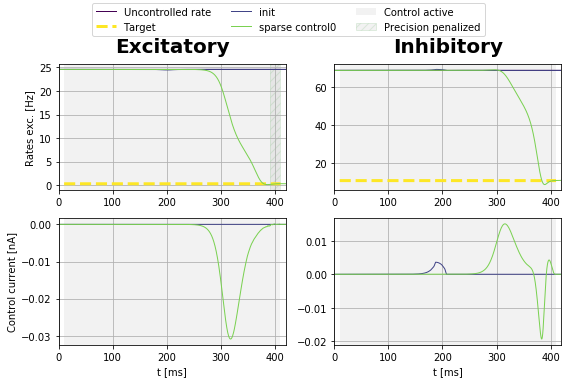

2


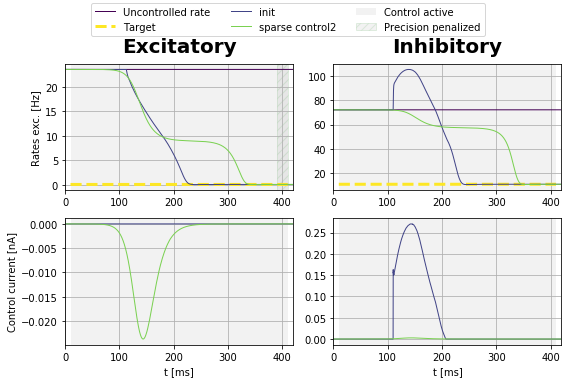

4


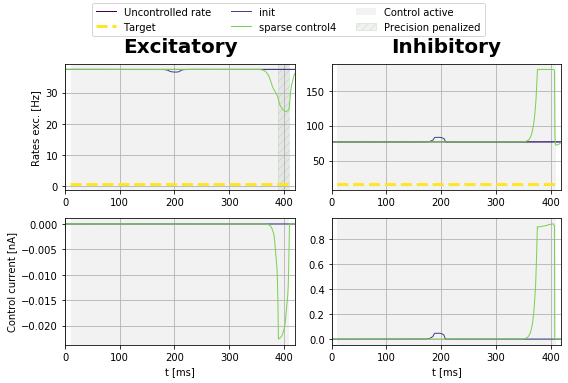

6


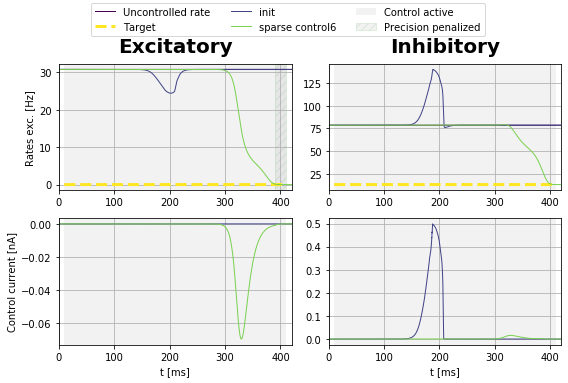

8


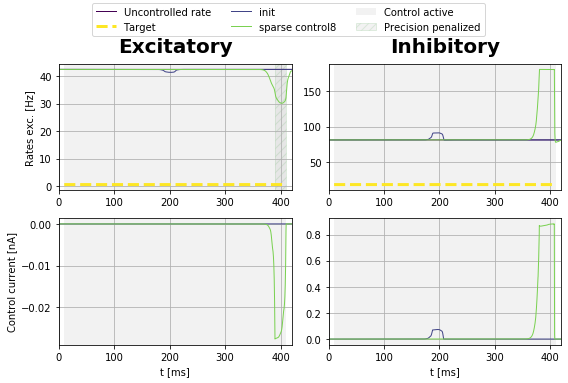

10


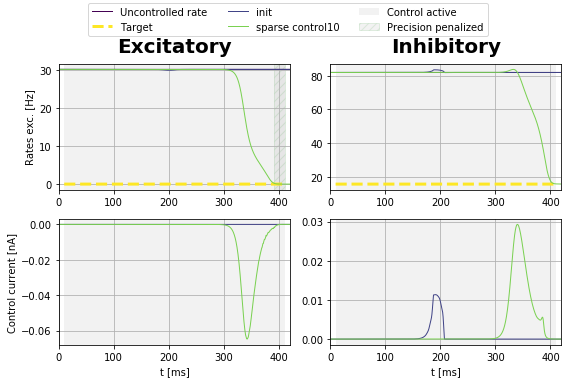

12


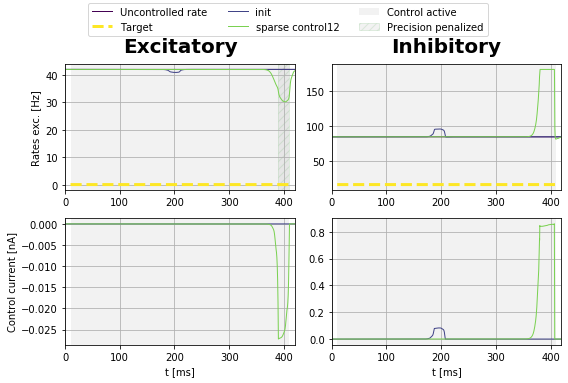

14


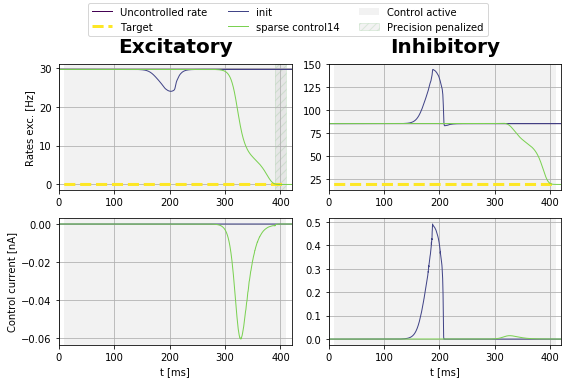

16


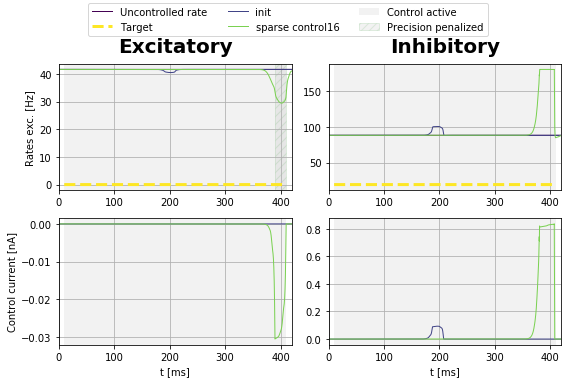

18


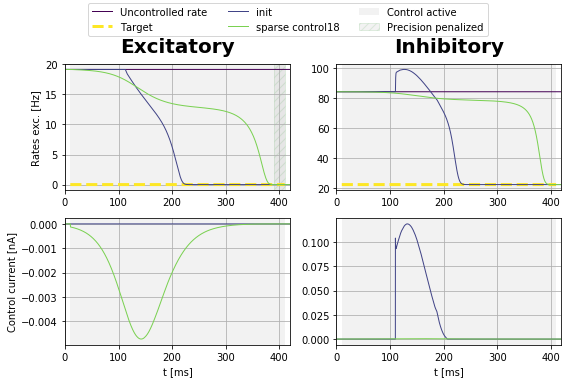

20


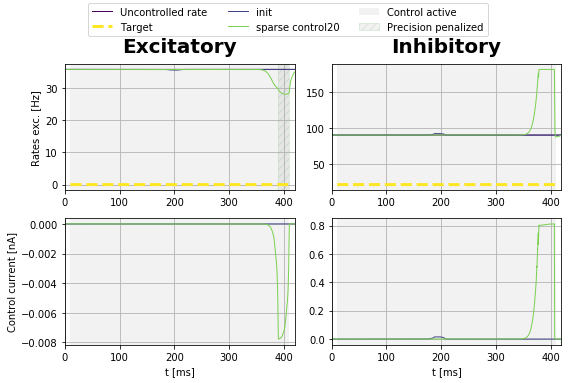

22


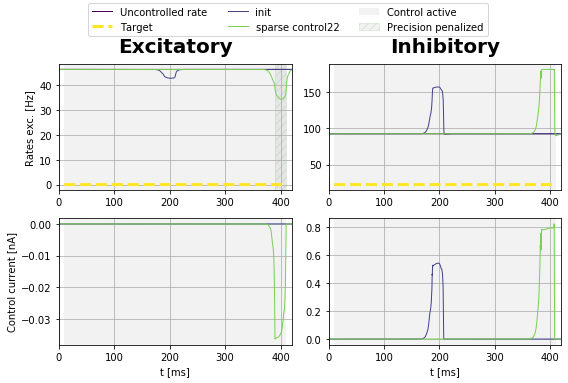

24


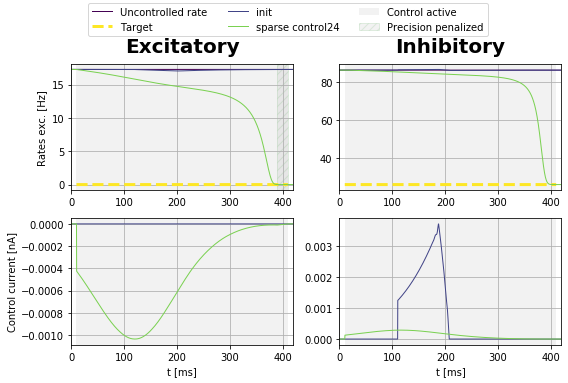

26


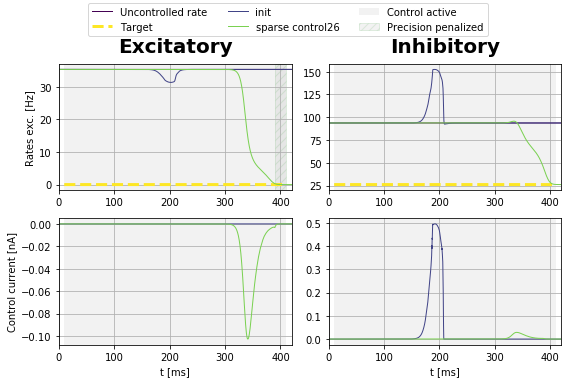

28


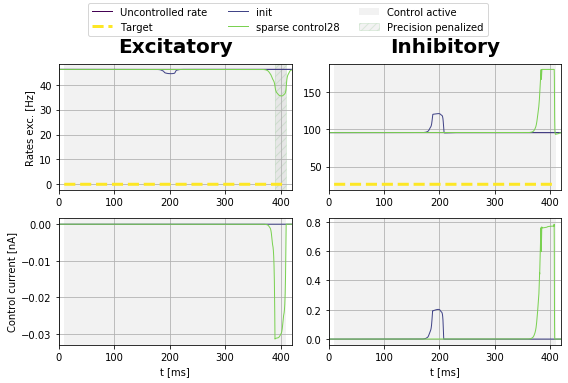

30


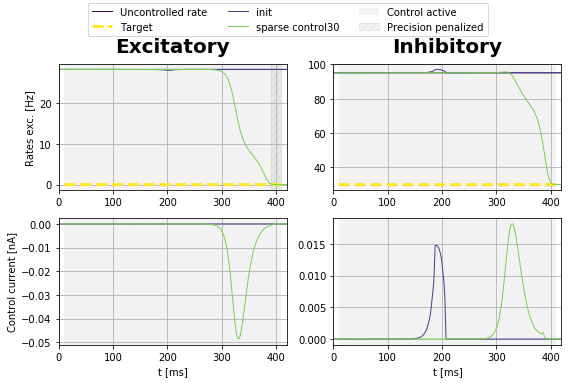

32


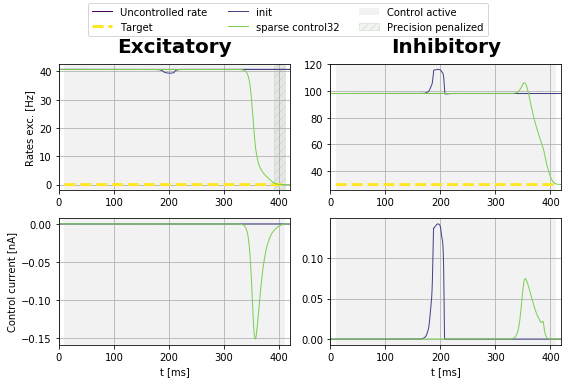

34


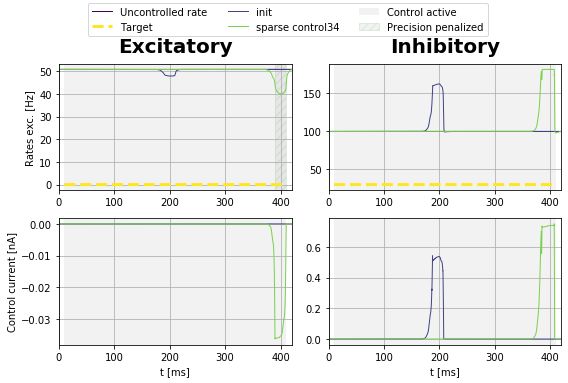

36


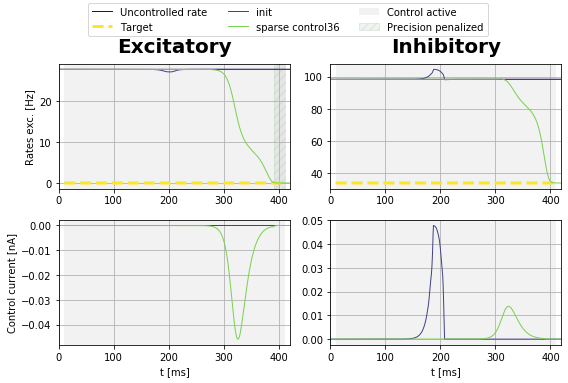

38


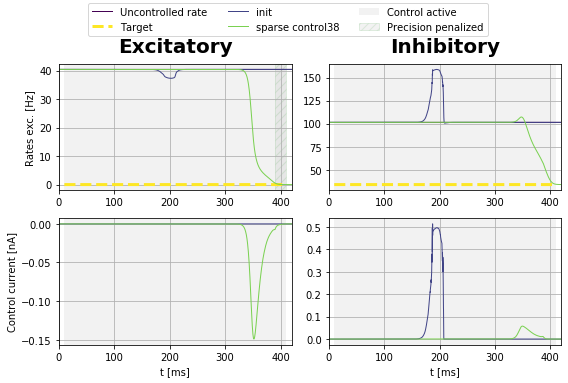

In [22]:
for i in i_range_1:
    
    print(i)
    
    aln.params.ext_exc_current = exc[i] * 5.
    aln.params.ext_inh_current = inh[i] * 5.

    plotFunc.plot_control_current(aln, [bestControl_init[i], bestControl_1[i]],
        [costnode_init[i], costnode_1[i]], [weights_init[i], weights_1[i]], dur,
        dur_pre, dur_post, initVars[i], target[i], '', filename_ = '', transition_time_ = trans_time,
        labels_ = ["init", "sparse control" + str(i)], print_cost_ = False)
    plt.show()